# Increasing the chances of your speech to go viral: an interrogation on what helps catch the attention of modern day fickle newsreaders 

## Context

We will try to use the Quotebank dataset complemented with information collected from Wikidata to answer the question of which factors contribute to a quote from a person going "viral" in the news.

We define a quote as viral if the number of times the quote was repeated exceeds a certain threshold, which we will choose to be 100 in Section [What is a Viral Quote?](#what_is_a_viral_quote). 

Before diving into the question, we will start by exploring the data extracted from both datasets: Quotebank and Wikidata. The first thing we'll do is analyze the number of occurrences of the quotes present in Quotebank and define the notion of virality. After that, we will try to find the relevant features that can have an impact on the virality of the quote. We will look both at the characteristics of the speakers as well as of the quoted text itself. With these features, we will build, train and cross-validate a model to try predicting the virality of a quote given the set of the extracted features.


## Datasets

### The Quotebank Dataset

Quotebank is a dataset of millions of quotations extracted from millions of English newspaper published between august 2008 to april 2020. For this project, we will only be used the quotes from 2015 onwards, and only the quotation-centric version of it.

This dataset contains the following information:
- `quoteID`: Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}").
- `quotation`: Text of the longest encountered original form of the quotation.
- `date`: Earliest occurrence date of any version of the quotation.
- `phase`: Corresponding phase of the data in which the quotation first occurred (A-E).
- `probas`: Array representing the probabilities of each speaker having uttered the quotation.
- `speaker`: Selected most likely speaker. This matches the the first speaker entry in `probas`.
- `qids`: Wikidata IDs of all aliases that match the selected speaker.
- `numOccurrences`: Number of time this quotation occurs in the articles.
- `urls`: List of links to the original articles containing the quotation. 


This description comes directly from the following website: [site](https://zenodo.org/record/4277311). Do not hesitate to use it if more details on the data are needed, as well as this [paper](https://dlab.epfl.ch/people/west/pub/Vaucher-Spitz-Catasta-West_WSDM-21.pdf).


### The Wikidata Dataset

Wikidata is a database containing a structured version of information about a subject being in Wikimedia. One can query wikidata to get some information about a specific subject. Wikidata uses [Identifiers](https://www.wikidata.org/wiki/Wikidata:Identifiers) (which we will refer to for the rest of the notebook as Query IDs, or QIDs) to assign a unique name to its objects. For more informations wikidata, you can refer to this [site](https://www.wikidata.org/wiki/Wikidata:Main_Page).

For each speaker, we will be querying and using the following informations:
- `Gender`: Gender(s) of the speaker. Usually male, female or None (non specified), and sometimes multiple ones are given.
- `Occupations`: Job(s) of the speaker, if not known None.
- `Date of Birth`: Date of birth of the speaker, sometimes not known (None) and sometimes ambiguity and multiple ones are given.
- `Nationality`: Nationality(ies) of the speaker, if not known None.
- `Religion`: Religion(s) of the speaker, if not known None.
- `Ethnicity`: Ethnicity(ies) of the speaker, if not known None.



## <a id='table_of_contents'></a> Table of Contents:
0. [Imports and Constants Definitions](#imports)
1. [Summarizing the data into a tractable dataframe](#summarizing_data_into_tractable_dataframe)
2. [Exploratory Data Analysis](#exploratory_data_analysis)
    1. [What is a Viral Quote?](#what_is_a_viral_quote)
    2. [Speakers' Features](#speaker_features)
        1. [Age](#age)
        2. [Gender](#gender)
        3. [Occupation](#occupation)
        4. [Nationality](#nationality)
        5. [Ethnicity](#ethnicity)
        6. [Religion](#religion)
        7. [Different Features Co-occurence](#heatmap)
        8. [Overall Number of Quotes with Missing Speaker Information](#overall) 
    3. [Length of Quotes](#len_quotes)
    4. [Extraction and Visualization of the Quote Topics](#extraction_visualization_quote_topics)
        1. [Theoretical explanation of BERTopic](#theory_bertopic)
        2. [Preprocessing of Quotebank to remove unusable quotes and extract features](#preprocessing_bertopic)
        3. [Training BERTopic model](#training_bertopic)
        4. [Visualize extracted topics](#visualize_topics_bertopic)
3. [Building the feature matrix and the labels](#build_features_labels)
4. [Relationship between features and output](#relationship_feature_output)
5. [Training virality classifiers](#training_classif)
    1. [Theoretical explanations of the methods used to perform the classification](#theory_classif)
        1. [Logistic Regression](#logistic_reg_theory)
        2. [Support Vector Machines](#svm_theory)
        3. [K-fold Cross-Validation](#cv_theory)
        4. [Test/train split](#train_test_theory)
    1. [Feature Selection for Classification](#classification_feature_selection)
    2. [Splitting Data into Training and Testing in a Stratified Manner](#stratified_train_test_split)
    
6. [Regressing number of occurences](#training_regression)
    1. [Theoretical explanations of the methods used to perform the regression](#theory_reg)
        1. [Linear Regression](#lin_reg_theory)

<a id='imports'></a>
# 0. Imports and Constants Definitions
[Back to table of content](#table_of_contents)

In [1]:
# Importing useful packages.
import numpy as np
import pandas as pd
import os
import bz2
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
from random import randrange
from bertopic import BERTopic
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing our utilitary modules.
import src.utils as utils
import src.feature_extraction as feature_extraction
import src.plot as plot

In [2]:
from itertools import cycle

In [3]:
# Defining constants.
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')
PREPROCESSED_DATASET_FILE_PATH = os.path.join(CACHE_DIR, "preprocessed_dataset.json.bz2")

<a id='summarizing_data_into_tractable_dataframe'></a>
# 1. Summarizing the data into a tractable dataframe
[Back to table of content](#table_of_contents)

In this section, we will be parsing the Quotebank dataset row by row and, with the help of the information about the speaker which we extracted from Wikidata, we will summarize it into a dataframe with the following columns:

- `Index`: the Wikidata QID associated to the each speaker contained in the Quotebanks dataset. One row with value None will aggregate all quotes for which the speaker is unknown.


- `quote_count`: the number of different quotes the speaker has been attributed in the Quotebanks dataset. This value is always a strictly positive integer.


- `age`: the average age of the speaker when he said each of the quotes assigned to it. We accepted to aggregate these values as an average for the data exploration step because the dataset only spans 5 years and we can consider that a negligible difference compared to the large age differences which we expect to observe between different speakers. This value can be NaN if the birth date of the speaker is unknown, as that prevents us from calculating age.


- `num_occurrences`: the total number of times any of the quotes assigned to the speaker has been repeated in a different news article. This value is always a strictly positive integer.


- `gender`: the gender that Wikidata assigns to the speaker. This value can be None if no gender is assigned to the speaker, is a list of one item if a unique gender is assigned to the speaker and a list with multiple items if multiple genders are assigned to the speaker (such as for transexual people).


- `occupation`: a list of occupations that Wikidata assigns to the speaker. This value can be None if no occupations are assigned to the speaker, otherwise it is always a list with at least one element.


- `nationality`: a list of nationalities that Wikidata assigns to the speaker. This value can be None if no nationalities are assigned to the speaker, otherwise it is always a list with at least one element.


- `ethnic_group`: a list of ethnicities that Wikidata assigns to the speaker. This value can be None if no ethnicities are assigned to the speaker, otherwise it is always a list with at least one element.


- `religion`: a list of religions that Wikidata assigns to the speaker. This value can be None if no ethnicities are assigned to the speaker, otherwise it is always a list with at least one element.

**Note:** Sometimes, multiple qids per speaker is found. This is because there are people having the same name but that are different and then we will get an ambiguity. To solve this ambiguity, we decided to query the linkcount of each wikidata of these ambigous speakers and chose to keep the qid of the person having the largest linkcount, because we assumed that the larger is a linkcount for a person, the more the person is famous and then the more it is likely to be quoted in a newspaper.

Additionally, we return the total number of quotes in the dataset, and the distribution of the number of occurrences and length of each quote.

In [4]:
@utils.cache_to_file_pickle("function-dataset_stats", cache_dir = CACHE_DIR)
def dataset_stats(data_dir, speaker_info_file_path):
    """
    Function for summarizing Quotebank dataset (with the help of Wikidata dataset) into a tractable dataframe.
    
    Params:
        data_dir::[str]
            Path of the directory containing the Quotebank dataset for each year as a separate .json.bz2 file.
        speaker_info_file_path::[str]
            Path for the speaker_attributes.parquet file (containing part of the informations collected from
            Wikidata about the speakers).
            
    Returns:
        num_quotes_count::[int]
            The total number of different quotes contained in the Quotebank dataset.
        num_occurrences_counts::[dict]
            Dictionary used as counter for the frequency with which the number of occurrences (used as key of the dictionary)
            occurs in the Quotebank dataset (count of each key is the corresponding value in the dictionary).
        speakers_info::[pd.DataFrame]
            DataFrame containing informations of each speaker in Quotebank dataset:
            quote_count, age, num_occurrences, gender, occupation, nationality, ethnic_group, religion.
    
    """
    qid_labels, linkcounts = utils.query_wikidata_for_linkcounts_and_labels(data_dir = data_dir, 
                                                                            speaker_info_file_path = speaker_info_file_path)
    speaker_data = utils.get_filtered_speaker_info_data(data_dir, speaker_info_file_path, 
                                                        columns = ['id', 'date_of_birth', 'gender', 'occupation',
                                                                   'nationality', 'ethnic_group', 'religion'])
    
    # Initialization of dictionaries for extracting meaningful features.
    num_quotes_count = 0
    num_occurrences_counts = {}
    len_quotes_counts = {}
    speakers_info = {}
    
    for line in utils.json_lines_generator(data_dir):        
        num_quotes_count += 1
        
        # Store the number of occurrences of this quote.
        line_num_occurrences = line['numOccurrences']
        num_occurrences_counts[line_num_occurrences] = num_occurrences_counts.get(line_num_occurrences, 0) + 1
        
        # Count the number of words in the quote and store it. This way of counting is not ideal for all quotes
        # (due to punctuation, speacial characters, ...) but is fast and gives a good approximation.
        line_len_quote = len(line['quotation'].split())
        len_quotes_counts[line_len_quote] = len_quotes_counts.get(line_len_quote, 0) + 1
        
        # Solve ambiguities in speaker qids due to homonyms.
        speaker = feature_extraction.solve_ambiguous_speakers(line['qids'], linkcounts)
        
        # Calculate speaker age. In case of missing value, None is used.
        speaker_birth_date = speaker_data.get(speaker, {}).get('date_of_birth', None)
        speaker_age = feature_extraction.get_speaker_age(speaker_birth_date, line['date'])
        
        # Add to the dictionary the number of quotes, the age and the number of occurences of the quotes for current speaker.
        # If necessary, make a new key for the current speaker in dictionary.
        if speaker in speakers_info:
            speakers_info[speaker]['quote_count'] += 1
            speakers_info[speaker]['age'].append(speaker_age)
            speakers_info[speaker]['num_occurrences'] += line_num_occurrences
        else:
            speakers_info[speaker] = {'quote_count': 1,
                                      'age': [speaker_age],
                                      'num_occurrences': line_num_occurrences}
            
            # If the speaker was not already in the dictionary, retrieve its gender, occupation, nationality, 
            # ethnic group and religion and add it to speaker_info. 
            # Before adding the information to the speaker_info dictionary, convert them from Wikidata QIDs to readable
            # english labels. If the information is not available (because speaker is unknown, that information for that
            # speaker is not available or the label of that information for that speaker is not available), None is added 
            # to the dictionary.
            for info_key in ['gender', 'occupation', 'nationality', 'ethnic_group', 'religion']:
                speaker_value = speaker_data.get(speaker, {}).get(info_key, None)
                speaker_value_labels = []
                if speaker_value is not None:
                    for qid in speaker_value:
                        label = qid_labels.get(qid, None)
                        if label is not None:
                            speaker_value_labels.append(label)

                speaker_value_labels = speaker_value_labels if len(speaker_value_labels) != 0 else None
                speakers_info[speaker][info_key] = speaker_value_labels
                
    # Convert the speaker_info dictionary into a dataframe and aggregate the ages of each speaker by averaging
    # across its quotes.
    speakers_info = pd.DataFrame(speakers_info).T
    speakers_info['age'] = speakers_info['age'].apply(lambda l: None if all(elem is None for elem in l) else np.mean(l))
    
    return num_quotes_count, num_occurrences_counts, len_quotes_counts, speakers_info


# Load the Quotebank and speaker_attribute dataset, extract the relevant infos for each speaker and generate a 
# tractable dataframe containing meaningful features.
num_quotes_count, num_occurrences_counts, len_quotes_counts, speakers_info = dataset_stats(data_dir = DATA_DIR, 
                                                                                           speaker_info_file_path = SPEAKER_INFO_FILE_PATH)

In [5]:
print(f"There are {num_quotes_count} quotes in the Quotebank dataset.")

There are 115584257 quotes in the Quotebank dataset.


In [6]:
print(f"For {speakers_info.loc[speakers_info.index.isna(), 'quote_count'].sum() / num_quotes_count:.2%} of quotes the speaker is unknown.")

For 34.60% of quotes the speaker is unknown.


In [7]:
if speakers_info.isin([[]]).any(axis = None):
    raise ValueError("Cells containing only empty list were detected in speaker_info dataframe!")
else:
    print("No cells containing only empty list were detected in speaker_info dataframe :)")

No cells containing only empty list were detected in speaker_info dataframe :)


<a id='exploratory_data_analysis'></a>
# 2. Exploratory data analysis

<a id='what_is_a_viral_quote'></a>
## 2.A. What is a Viral Quote?
[Back to table of content](#table_of_contents)

In this section, we will analyze the number of occurences of all the quotes present in the dataset. With this, we will define the threshold above which a quote will be considered as viral.

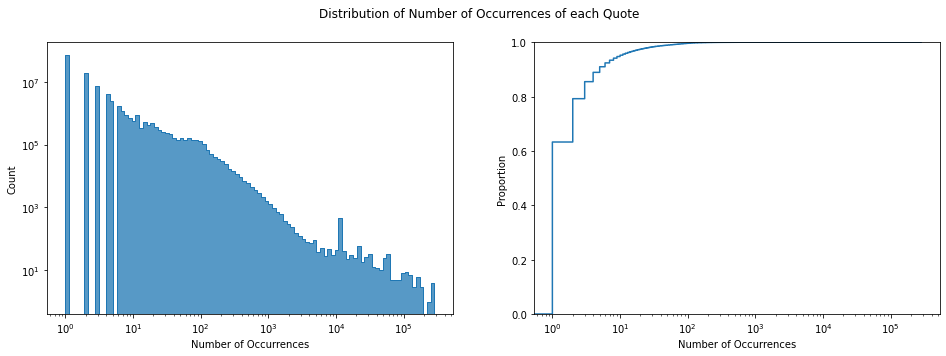

In [8]:
# Visualization of the distribution of number of occurences for each quote in the dataframe.
plot.plot_hist_ecdf(pd.DataFrame(num_occurrences_counts.items(), columns = ['Number of Occurrences', 'Count']),
                    x = 'Number of Occurrences',
                    weights = 'Count',
                    title = 'Distribution of Number of Occurrences of each Quote', 
                    hist_kwargs = {'bins': 100, 'log_scale': (True, True), 'element': 'step'}, 
                    ecdf_kwargs = {'log_scale': (True, False)})

In [9]:
print("Statistics of Number of Occurrences of each Quote:\n")
print(utils.describe_weighted_stats(num_occurrences_counts.keys(), num_occurrences_counts.values(),
                                    percentiles = [0.95, 0.97, 0.99, 0.995, 0.999]).to_string(float_format = '{:.10g}'.format))

Statistics of Number of Occurrences of each Quote:

count     115584257
mean    3.992644967
std     113.8343316
min               1
25.0%             1
50.0%             1
75.0%             2
95.0%            10
97.0%            17
99.0%            55
99.5%            90
99.9%           215
max          282552


In [10]:
# Define a viral quotes as a quotes that has at least 100 occurences.
VIRAL_THR = 100

num_cited_more_thr = sum(value for key, value in num_occurrences_counts.items() if key >= VIRAL_THR)
num_cited_less_thr = sum(value for key, value in num_occurrences_counts.items() if key < VIRAL_THR)

print(f"{num_cited_less_thr/(num_cited_less_thr + num_cited_more_thr):.3%} of quotes are quoted less than {VIRAL_THR} times")
print(f"Quotes cited {VIRAL_THR} times or more:", num_cited_more_thr)
print(f"Quotes cited less than {VIRAL_THR} times:", num_cited_less_thr)

# Cleanup cell temporary variables.
del num_cited_more_thr, num_cited_less_thr

99.587% of quotes are quoted less than 100 times
Quotes cited 100 times or more: 477879
Quotes cited less than 100 times: 115106378


<a id='speaker_features'></a>
## 2.B. Speakers' Features
[Back to table of content](#table_of_contents)

In this section, we will analyze the features of the speaker.

At first, we will explore the raw distribution of the speaker's features and, after that, we will weight the distribution in 2 different ways. In the first way, the distribution will be weighted by the number of quotes said by a speaker and in the second way, it will be weighted by the total number of occurences of the quotes said by a speaker. As we want to train a classifier from those features, we will always keep an eye on the number of quotes for which the feature is missing. We will further analyze the features with a reasonable percentage of missing values.

In the further analysis, we will look at feature for which multiple values are given for one speaker and analyze the co-occurences of these different values. Additionnaly, we will also analyze the co-occurences between different features.

<a id='age'></a>
### 2.B.a. Age

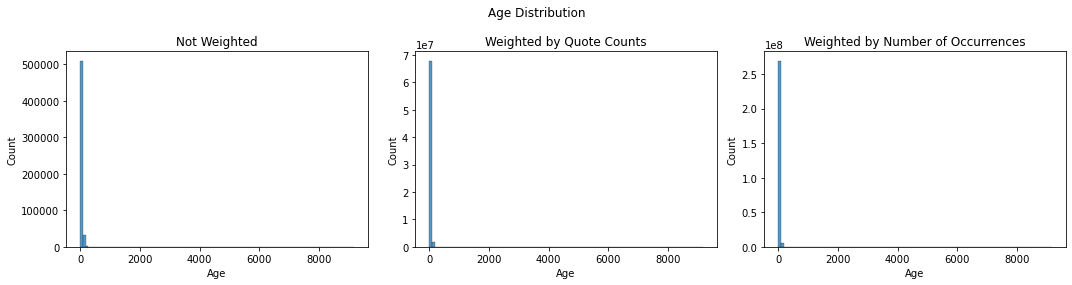

In [11]:
plot.plot_speaker_feature_distribution(speakers_info, 'age', bins = 100, figsize = (15, 4))

In [12]:
print("Statistics of Age of each Speaker (not weighted by quote counts or occurrences counts):\n")

print(speakers_info['age'].describe().to_string(float_format = '{:.6g}'.format))

Statistics of Age of each Speaker (not weighted by quote counts or occurrences counts):

count     543208
mean     54.3443
std      50.0529
min     -4.90909
25%           36
50%           52
75%           67
max      9168.28


As we can see from the above plots and computed statistics, we have some extremely large values for the age. These values are due to quotes being attributed to people being long dead at the time of the quote. We can observe that some speakers are assigned negative ages, which is the result of an incorrect assignement of the birth date in Wikidata, or of an incorrect assignement of the speaker in our algorithm which solves for homonyms.

To deal with both cases, we will limit ourselves to ignoring quotes coming from people which have a calculated age of less than 5 years or more than 95 years. Note that a better approach may be to query Wikidata for whether the person is dead, but we don't expect this result to be significantly different. We can afford to discard these quotes because they represent a very tiny minority of the data, but even more importantly because they would not bring any valuable insight into the question at hand, as that concerns people that at the time of the quote were adults or young adults which benefited from media coverage.

Focusing only on the desired range of ages, we get the results in the next cells.

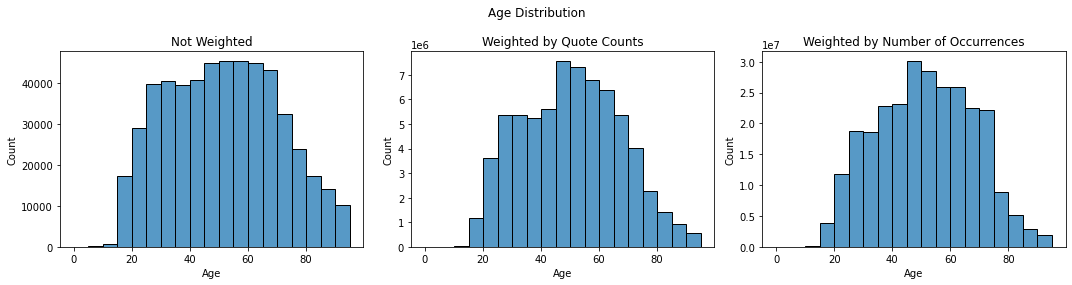

In [13]:
plot.plot_speaker_feature_distribution(speakers_info, 'age', bins = range(0, 100, 5), figsize = (15, 4))

In [14]:
MIN_AGE = 5
MAX_AGE = 95

print("Statistics of Age of each Speaker (not weighted by quote counts or occurrences counts):\n")
print(speakers_info.loc[(speakers_info['age'] >= MIN_AGE) & (speakers_info['age'] <= MAX_AGE), 'age'].describe().to_string(float_format = '{:.6g}'.format))

Statistics of Age of each Speaker (not weighted by quote counts or occurrences counts):

count    528660
mean     51.332
std     19.1952
min           5
25%      35.475
50%     51.1912
75%     65.9861
max          95


In [15]:
ages = speakers_info[['age', 'quote_count']]
print(f"{(ages['age'].isna() * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker for which age couldn't be determined.")
ages = ages.dropna()
print(f"{((ages['age'] < MIN_AGE) * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker with an age smaller than {MIN_AGE}.")
print(f"{((ages['age'] > MAX_AGE) * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker an age larger than {MAX_AGE}.")

# Cleanup cell temporary variables.
del ages

39.59461% quotes have speaker for which age couldn't be determined.
0.00724% quotes have speaker with an age smaller than 5.
1.04461% quotes have speaker an age larger than 95.


As we can see from these results, 50% of the speakers in our dataset have ages lying between 19 and 66, with the median being at 51. These results coincide with what we expected: the speakers benefitting from media coverage are mainly young adults and middle-aged men (only a minority are children or elderly people).

We also see that for almost 40% of quotes the age of the speaker couldn't be determined, and hence these quotes will not be used when training our models. It should be noted that this value also includes the 34.60% of quotes for which the speaker is completely unknown.

Finally, we can observe that the distribution changes when weighting by the number of quotes and number of occurrences compared to when not weighting. This suggests that the distribution of ages for people which have been quoted at least once in their lives by any newspaper is quiet uniform between 25 and 70 years of age, but the distribution of people which are frequently cited and for which every citation is repeated several times is more concentrated between the ages of 35 to 75.

<a id='gender'></a>
### 2.B.b. Gender

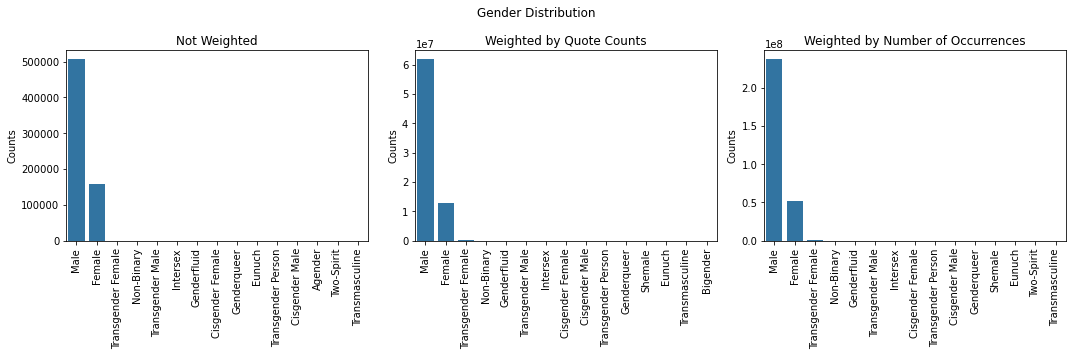

In [16]:
plot.plot_speaker_feature_distribution(speakers_info, 'gender', n_bars = 15, figsize = (15, 5))

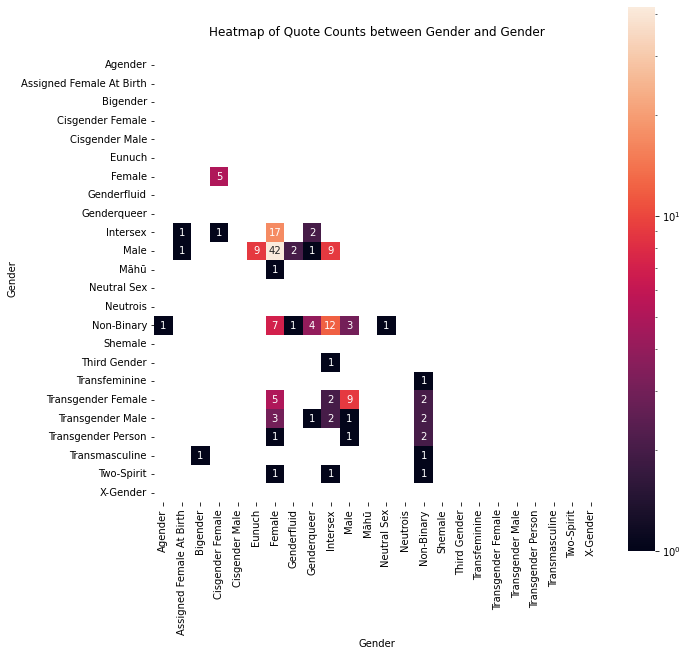

In [17]:
plot.plot_co_occurrence_matrix(speakers_info, 'gender', 'gender', annot = True)

In [18]:
print(f"{(speakers_info['gender'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which gender couldn't be determined.")
print(f"{speakers_info['gender'].isin([['Male'], ['Female']]).sum() / (~speakers_info['gender'].isna()).sum():.5%} of speakers are either Male or Female.")

35.38609% quotes have speaker for which gender couldn't be determined.
99.88410% of speakers are either Male or Female.


As we can see from these results, the vast majority of speakers is either male or female. For this reason, in later parts of the notebook the possible genders will be grouped into 3 classes: male, female or other.

We also see that for a little more than 35% of quotes the gender of the speaker couldn't be determined, and hence these quotes will not be used when training our models. It should be noted that this value also includes the 34.60% of quotes for which the speaker is completely unknown.

We observe that the distribution changes when weighting by the number of quotes and number of occurrences compared to when not weighting. This change suggests that males are quoted more often by the media, and their quotes are repeated more times than females. 

Finally, by looking at the co-occurences of the genders when multiple ones are given, we interestingly observe that the highest co-occurence is between male and female. By looking at several speaker where this is the case, we observed that in the wikipedia page there is no ambiguity because of the use of female/male pronouns, but the wikidata contains male and female genders. We then concluded that these data are probably not correct.

<a id='occupation'></a>
### 2.B.c. Occupation

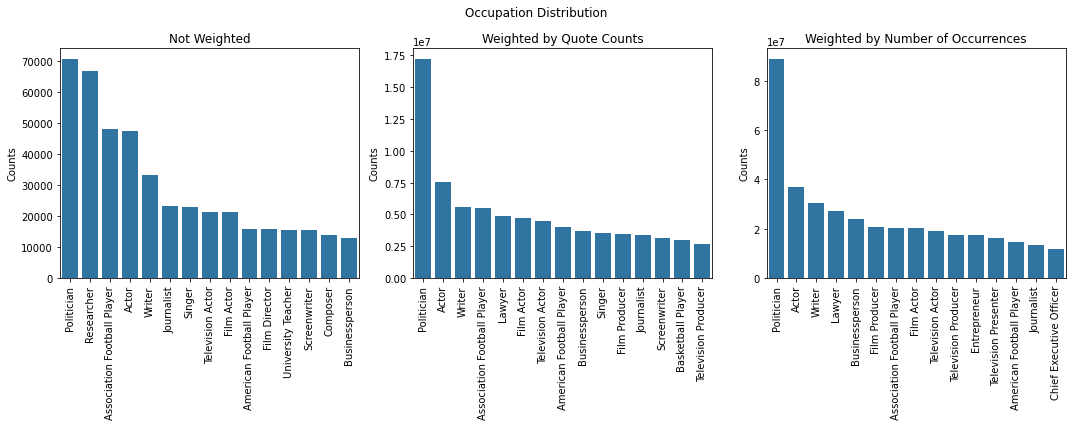

In [19]:
plot.plot_speaker_feature_distribution(speakers_info, 'occupation', n_bars = 15, figsize = (15, 6))

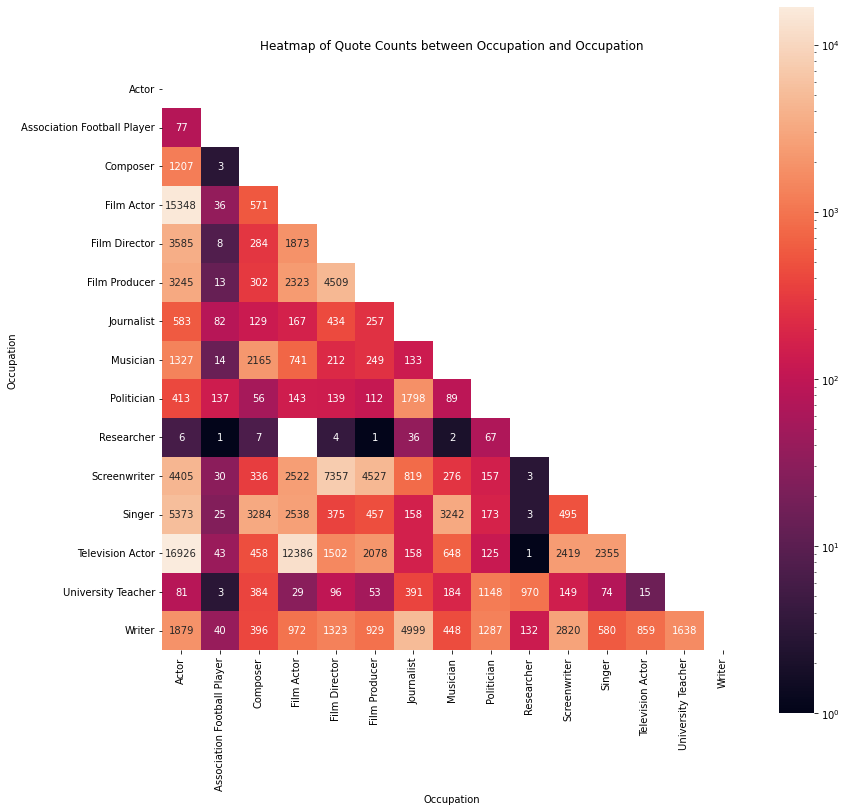

In [20]:
plot.plot_co_occurrence_matrix(speakers_info, 'occupation', 'occupation', keep_top_n = 15, figsize = (13, 13))

In [21]:
print(f"{(speakers_info['occupation'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which occupation couldn't be determined.")

36.31545% quotes have speaker for which occupation couldn't be determined.


As we can see from these results, and as expected, there are three main professions which are present in newspaper quotes:

1) *Politicians*: since the dataset is made from newspapers articles, it makes a lot of sense that politicians would both be the most quoted, both in terms of different people quoted, but even more in terms of the number of different quotes and repetitions of each quote.

2) *Sport related professions*: this one also makes sense as sports plays such an important role in our society that, with such a large number of sports enthusiasts, basically every newspaper has a sports section. 

3) *Artistic professions* (actors, writers, singers, journalists etc...) and *business-related professions* (businesspeople, lawyers, ...): it makes once again a lot of sense that artistic and business-related professions would rank high in the list of professions with most media coverage for the same reason as the sports related professions. Moreover, it should be noted that often politicians are not only assigned a single occupation, with many also being or having been lawyers, businesspeople, actors... This is clearly visible from the co-occurency matrix of the occupations.

It is interesting to note that researcher rank as the second most cited occupation when considering only the number of different people contained in the dataset, but don't even rank in the first 15 when weighting by the number of quotes and number of occurrences. This suggests that several researchers may be interviewed and quoted on a particular subject, but each of their opinions would not be repeated very often, nor there would be a significant number of researchers which are asked for their opinion particularly often (compared to the other professions).

One important thing that we can observe from these graph is that politicians, actors and influencers in general are well represented in this dataset, which is good for us as it is towards these people that our research is geared towards. Later in the notebook, we will use only a few of the most common occupations to train the model in order to avoid increasing the number of features too much and incurring the curse of dimentionality.

Another important thing to notice is that some professions are labelled in multiple ways, such as actors, film actors, television actors, ... and as we can see from the co-occurrency matrix, often all these labels are assigned to each person. As such we will probably want to manually merge them into a single one when generating the training data.

<a id='nationality'></a>
### 2.B.d. Nationality

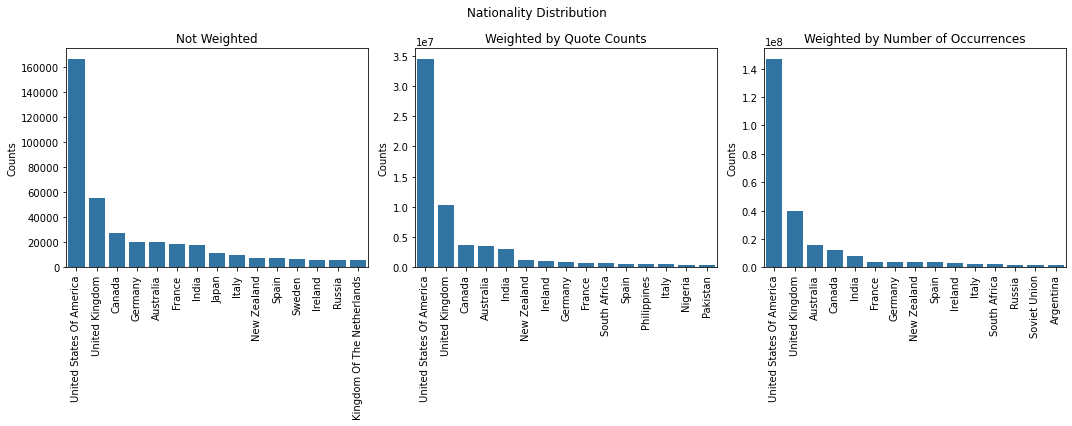

In [22]:
plot.plot_speaker_feature_distribution(speakers_info, 'nationality', n_bars = 15, figsize = (15, 6))

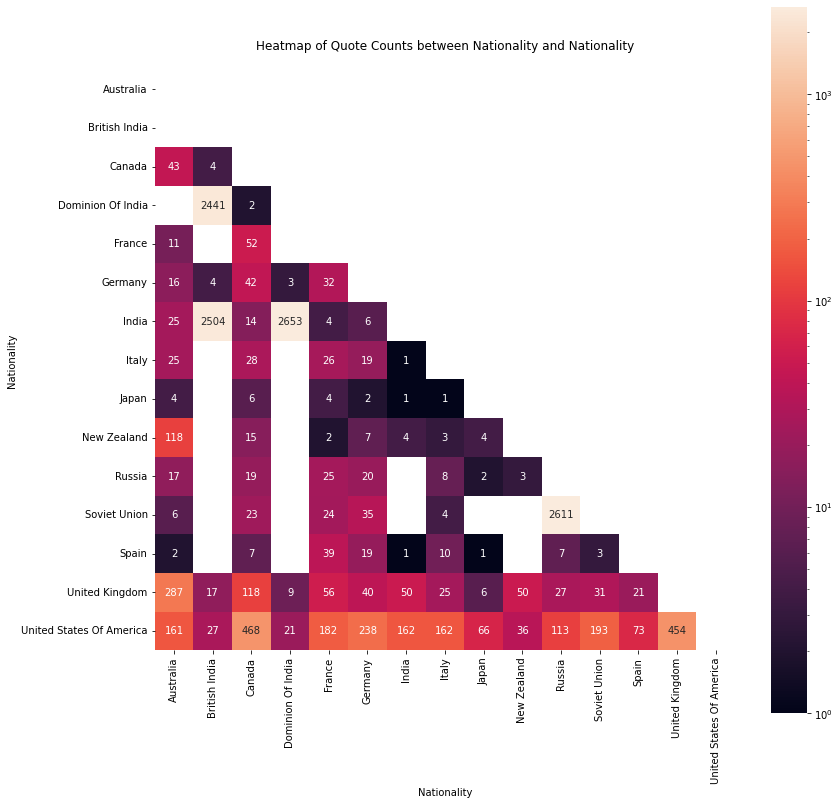

In [23]:
plot.plot_co_occurrence_matrix(speakers_info, 'nationality', 'nationality', keep_top_n = 15, figsize = (13, 13))

In [24]:
print(f"{(speakers_info['nationality'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which nationality couldn't be determined.")

41.65162% quotes have speaker for which nationality couldn't be determined.


As we can see from these results, there is a big over-representation of people from english-speaking countries in the Quotebank dataset. This is not very surprising, as the dataset is built from newspaper articles written in English.

We also see that for almost 42% of quotes the nationality of the speaker couldn't be determined, and hence these quotes will not be used when training our models. It should be noted that this value also includes the 34.60% of quotes for which the speaker is completely unknown.

Looking at the cross occurence matrix, we observe the same trend where UK, Indian, US and other english countries are over represented and thus more people possessing one of these nationalities also possess another simply through sheer number difference. The cross occurence matrix does allow us to spot out that india, Dominion of India and other india variations should be merged together if we want this to be parameter to be a feature, even though that it is quite unlikely that we will keep this as a feature because it would bias our model into thinking that it is necessary to be from an english speaking country to be more quoted. 

Later in the notebook, we will use only a few of the most common nationalities to train the model (if we even do) in order to avoid increasing the number of features too much and incurring the curse of dimentionality.

<a id='ethnicity'></a>
### 2.B.e. Ethnicity
Let's glance at the representation of ethnic groups in our dataset and try to determine if it is an interesting feature and if there are any biases we should be careful of.

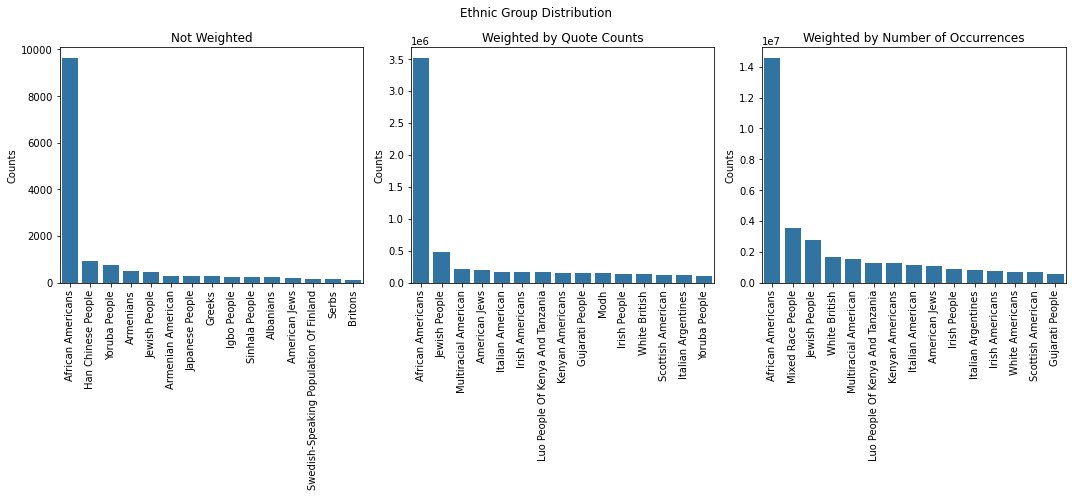

In [25]:
plot.plot_speaker_feature_distribution(speakers_info, 'ethnic_group', n_bars = 15, figsize = (15, 7))

In [26]:
print(f"{(speakers_info['ethnic_group'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which ethnic_group couldn't be determined.")

93.97735% quotes have speaker for which ethnic_group couldn't be determined.


As we can see from these results, only 6% of speakers in the whole dataset have a known ethnic origin. Upon futher inspection, it would seem Wikidata does not assign an ethnicity to several important caucasian people, which we are interested in including in our study. A reason for this bias could have been that a major part of the population is not aware of their actual origins, while demographic minorities may have a strong identity sense which leads them to fill out the information. 

We are left with no choice but to consider this data highly volatile, non representative, and unexploitable.

Nonetheless, an interesting fact to observe is that one category leaps up the rankings when considering number of quotes and occurences: multiracial americans. Obama being registered in Wikidata as a member of this category might explain this leap in representation? This could be an interesting topic to consider in the data story, are specific individuals biasing us because of their overwhelming quote counts and weights

<a id='religion'></a>
### 2.B.f. Religion

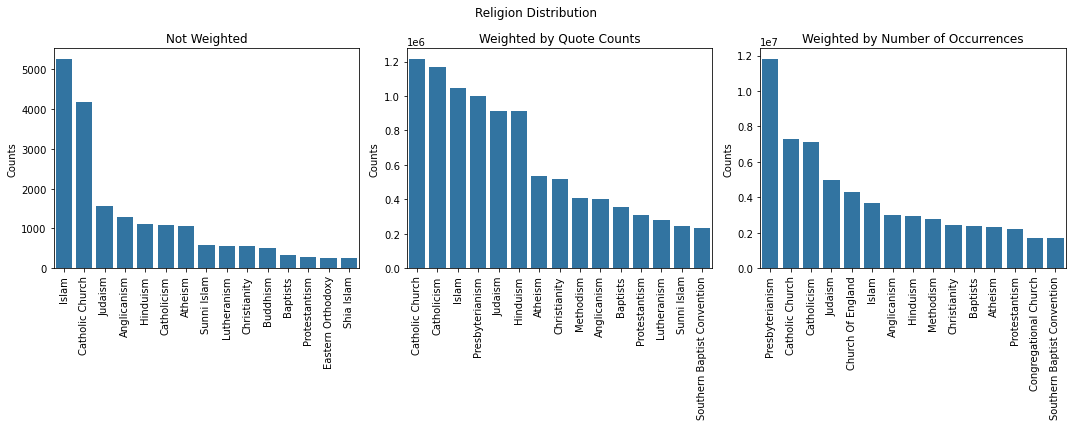

In [27]:
plot.plot_speaker_feature_distribution(speakers_info, 'religion', n_bars = 15, figsize = (15, 6))

In [28]:
print(f"{(speakers_info['religion'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which religion couldn't be determined")

90.29055% quotes have speaker for which religion couldn't be determined


As we can see from these results, only 10% of speakers in the whole dataset have a known religion.
The distribution is once again similar to that of english speaking countries : When looking at Quote count and number of occurences we have prebysterianism, the catholic church, The Church of England/Anglicanism Hinduism being over represented which makes sense considering our initial dataset.

We again see the importance of considering features with the proper weights, at first glance Islam might seem to be the most represented religion in the quotes but that is actually not the case, catholic based religions occupy a majority of quote counts in our newspapers which makes sense since the main dataset nationalities originate from the US.


<a id='heatmap'></a>
### 2.B.g. Different Features Co-occurence

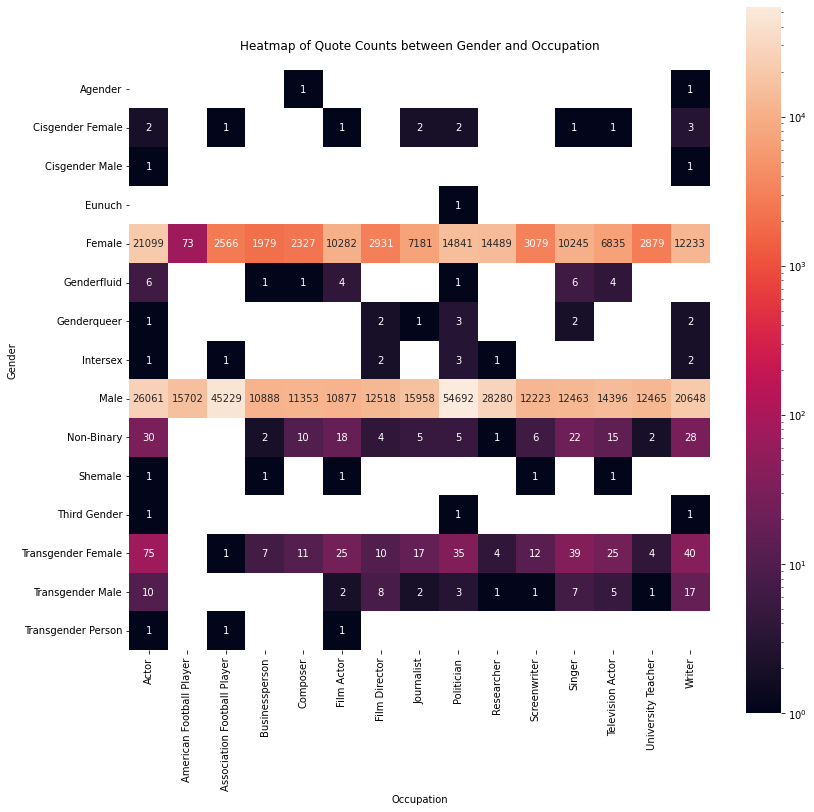

In [29]:
plot.plot_co_occurrence_matrix(speakers_info, 'gender', 'occupation', keep_top_n = 15, figsize = (13, 13))

We see  that the crushing majority of people label themselves as either male or female which means all the big values are on these lines. We also see that for some occupations the ratio between males and females is not the same as for most other occupations. This is particularly visible for football players, businesspeople and film directors. For this reason, we will need to pay attention to the coefficient assigned by the models to the gender when one of the unbalanced professions is deemed important to describe the virality. All other genders are so heavily under-represented that we do not expect them to cause any meaningful bias to the models.

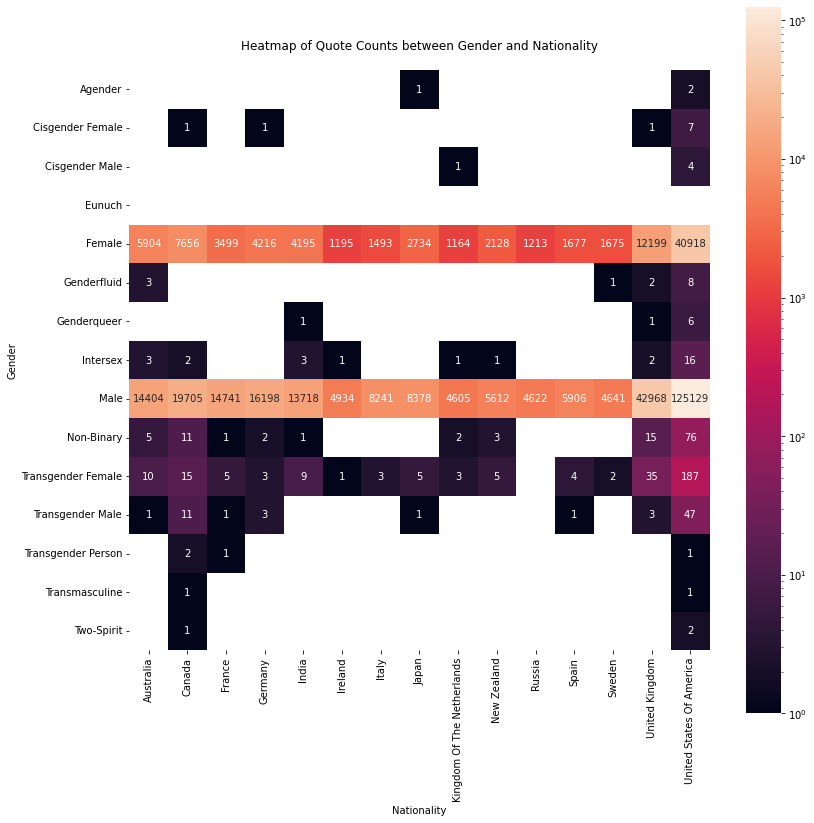

In [30]:
plot.plot_co_occurrence_matrix(speakers_info, 'gender', 'nationality', keep_top_n = 15, figsize = (13, 13))

Again we note that in every culture the number of wemen is lower than that of men. However, the ratio between the number of mails and females does not appear to change significantly across nations, which is good to avoid hidden bias of the models.

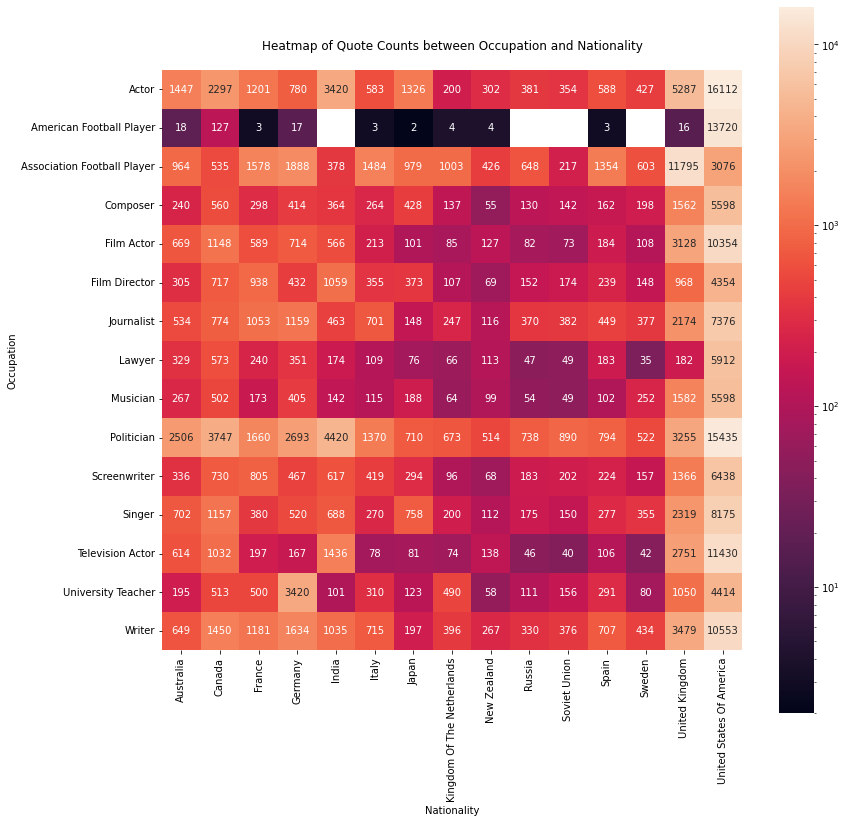

In [31]:
plot.plot_co_occurrence_matrix(speakers_info, 'occupation', 'nationality', keep_top_n = 15, figsize = (13, 13))

From this table we can clearly see that there are some professions which are very uncommon in certain nations while being very common in others. A clear exemple of this is the american football player occupation, which is completely missing from countries such as India and Russia. For this reason, we will need to pay attention to the coefficient assigned by the models to the nationality when one of the unbalanced professions is deemed important to describe the virality. It is also interesting to note that politicians are indeed the most quoted across all countries.

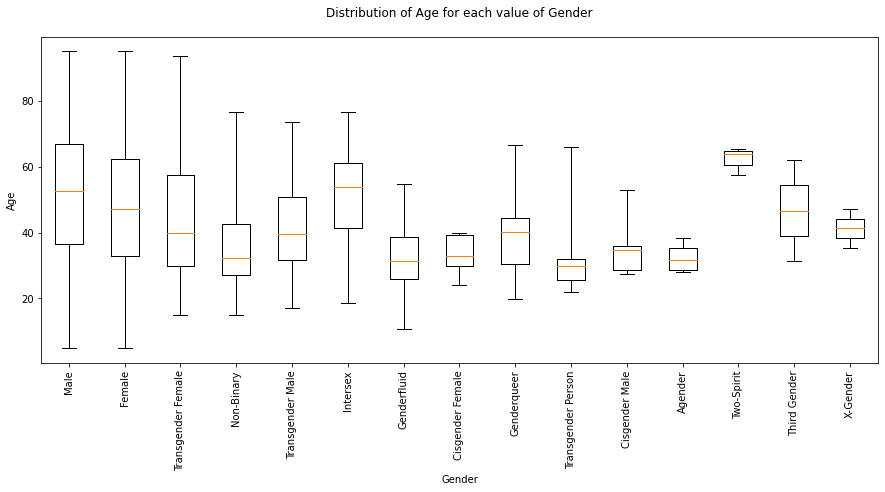

In [32]:
plot.plot_boxplot_for_each_discrete_value(speakers_info, 'age', 'gender', keep_top_n = 15, filter_func = lambda age: MIN_AGE <= age <= MAX_AGE, figsize = (15, 6))

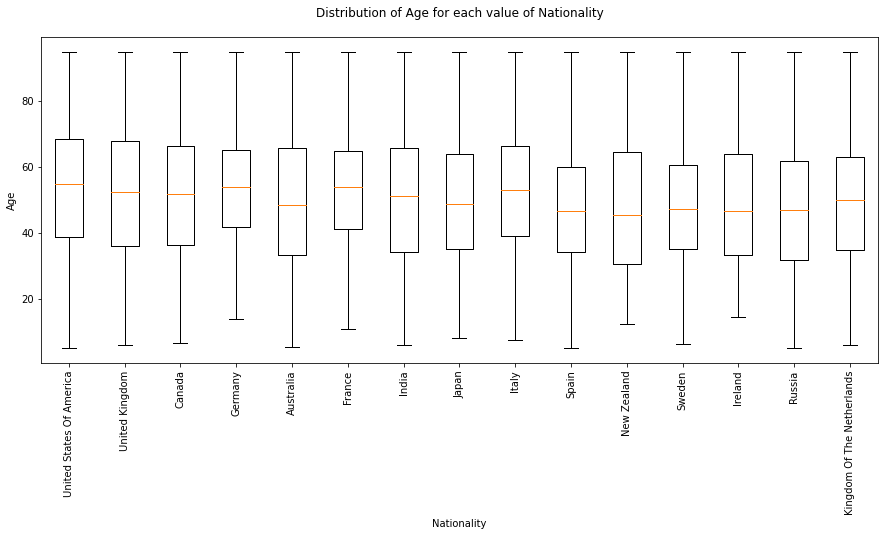

In [33]:
plot.plot_boxplot_for_each_discrete_value(speakers_info, 'age', 'nationality', keep_top_n = 15, filter_func = lambda age: MIN_AGE <= age <= MAX_AGE, figsize = (15, 6))

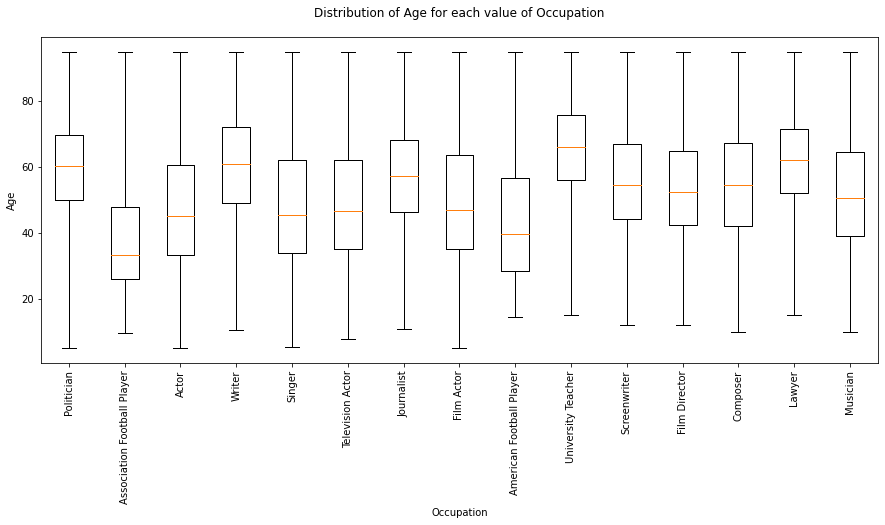

In [34]:
plot.plot_boxplot_for_each_discrete_value(speakers_info, 'age', 'occupation', keep_top_n = 15, filter_func = lambda age: MIN_AGE <= age <= MAX_AGE, figsize = (15, 6))

These boxplots represent the distribution of age between the different features. The age values are already filtered such that they range between 5 and 95.

As we can see from the results, the age distributions for Male and Female are quite similar, with the Male having a distribution slightly more skewed towards larger values than females. For the other genders we can observe that there is a higher variation in the distributions. This is due to the fact that in these groups the number of speakers is very small and therefore their distribution is noisy. These results reinforce our decision of regrouping all gender different than Male and Female in a unique group.

From the boxplots of age for different nationalities, we can see that the age distribution seems uniform across all nations.

From the boxplot for the different occupation we can notice that the politician, writer, journalist university teachers and lawyer have the age distribution with the highest median. We can see that occupations that requires physical activities like football player have a lower median. Finally, we can observe that occupation more related to the art domain like actor, singer and composer have an age distribution that range between 30 and 50 year. Once again, due to this reason, we will need to pay attention to the coefficient assigned by the models to the age when one of the aforementioned professions is deemed important to describe the virality.

<a id='overall'></a>
### 2.B.h. Overall Number of Quotes with Missing Speaker Information

In [35]:
features_we_are_going_to_use = ['age', 'gender', 'occupation', 'nationality']

print(f"{(speakers_info[features_we_are_going_to_use].isna().any(axis = 1) * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker information missing.")

# Cleanup cell temporary variables.
del features_we_are_going_to_use

43.72213% quotes have speaker information missing.


We chose to discard the quotes with missing speaker info from our dataset because it still leaves up with more than 60 million quotes to train on, which we believe are going to be more than enough and also likely to be the relatively more useful ones.

<a id='len_quotes'></a>
## 2.C. Length of Quotes
[Back to table of content](#table_of_contents)


In this section we will analyze the length of quotes with graphical plots of the distribution and numerical statistics.

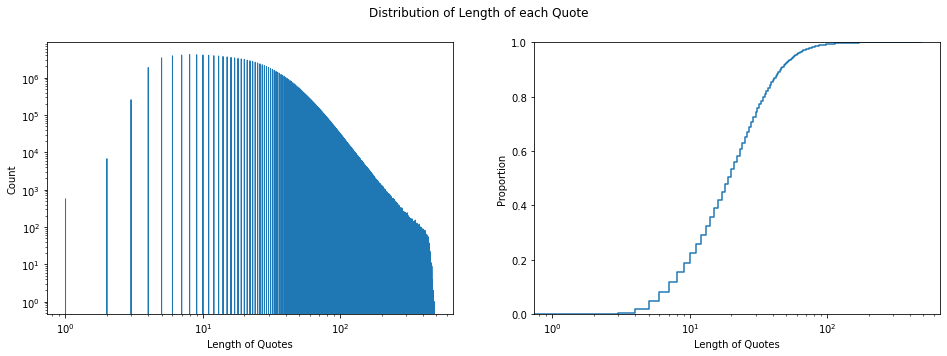

In [36]:
# Visualization of the distribution of number of the length of the quotes.
plot.plot_hist_ecdf(pd.DataFrame(len_quotes_counts.items(), columns = ['Length of Quotes', 'Count']),
                    x = 'Length of Quotes',
                    weights = 'Count',
                    title = 'Distribution of Length of each Quote', 
                    hist_kwargs = {'bins': 10000, 'log_scale': (True, True), 'element': 'step'}, 
                    ecdf_kwargs = {'log_scale': (True, False)})

In [37]:
print("Statistics of Length of each Quote:\n")
print(utils.describe_weighted_stats(len_quotes_counts.keys(), len_quotes_counts.values(),
                                    percentiles = [0.1, 0.95]).to_string(float_format = '{:.10g}'.format))

Statistics of Length of each Quote:

count     115584257
mean    24.06191121
std     19.23396986
min               1
10.0%             7
25.0%            11
50.0%            19
75.0%            31
95.0%            58
max             483


As we can see from these results, 50% of the quotes have length under 20 words, and 25% have length less than 10%. More than 95% of the quotes are less than 60 words, but printing some of the longest ones confirmed us that most of them were still perfectly valid quotes, altough long, up until 450 words. Similarly, even quotes as small as a single word are often correct, altough not very meaningful quotes.

For all future analyses we will discretize the distribution of quote lengths into short (length of quote is smaller than 25th percentile), long (length of quote is larger than 25th percentile) and medium (if neither of previous conditions is true).

<a id='extraction_visualization_quote_topics'></a>
## 2.D. Extraction and Visualization of the Quote Topics
[Back to table of content](#table_of_contents)

In this section, we will present the technique we used to extract the topics from the quotes, describe its core functioning, and of course implement it, train it and visualize the resulting topics.

<a id='theory_bertopic'></a>
### 2.D.a Theoretical explanation of BERTopic

`BERTopic`<sup>[[1]](https://github.com/MaartenGr/BERTopic) [[2]](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6) [[3]](https://towardsdatascience.com/interactive-topic-modeling-with-bertopic-1ea55e7d73d8)</sup> is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic description. This model is composed of four main algorithms, each doing a different job:
1. Extraction of embeddings from text documents: this can be done in many different ways, but we opted towards using one of the lighter pre-trained [BERT](https://en.wikipedia.org/wiki/BERT_(language_model) models from [Sentence Transformers](https://github.com/UKPLab/sentence-transformers), which is natively supported by the BERTopic package. From a high-level perspective, this step consists in feeding a piece of text to a pre-trained neural network ([BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) in our case), which then gives a vector as output which is the representation of the said piece of text in an (often high-dimensional) euclidean space. The characteristic of these embeddings is that the model was trained such that sentences that are semantically similar (have similar meanings) should map to close vectors in the euclidian space.


2. Dimensionality reduction: BERTopic uses [UMAP](https://github.com/lmcinnes/umap) to reduce the dimensionality of the embeddings found in the previous step while still maintaining as much of the high-dimensional global structure as possible. How UMAP achieves this is by fitting a manifold on the data, under certain assumptions. The mathematical details can be found on their [Github page](https://github.com/lmcinnes/umap) and in their [paper](https://arxiv.org/abs/1802.03426).


3. Clustering: BERTopic uses [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan) to cluster the now low-dimensional embeddings of the quotes into topics. HDBSCAN is a density-based clustering algorithm, which means that for it to work correctly, the embeddings we give him must be close in the euclidian space. Luckily, as explained earlier, UMAP preserves local structures of the high-dimensional space in its low-dimensional mapping, and as a result, the clustering performed in low-dimensional space (should) yield the same thing as if it was performed in the high-dimensional space (just much faster and much more stable). As a result, we expect quotes clustered by HDBSCAN to be semantically similar.


4. Topic creation from clusters: to extract the topic meanings (in the form of the most important words used to represent the topic) the author of BERTopic applied the concept of `TF-IDF`, explained both in this [Wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and in [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) to each cluster obtained from the previous step. `TF-IDF` is a technique used to make an embedding of a document into the euclidian space. It takes as input the word count of the document and outputs an embedding such that the words which appear very often in it have a scaled-down impact on the final embedding, as they are expected to be common to any sentence in that particular language and hence not likely to bear much meaning about the topic of the document. How this idea was applied in BERTopic is by simply merging all the training quotes that have been clustered into a topic into a single large text document (by simply concatenating the strings) and applying TF-IDF on it (this variant bears the label of c-TF-IDF as given by the author of BERTopic). This way, looking at the largest TF-IDF scores in the words of the documents in the cluster we can get the most semantically significant words for that topic.


The exact way in which the c-TF-IDF score of a word is calculated is as follows (naturally this computation is performed in vectorized form for all words in the topic at once):

$$\text{c-TF-IDF}_i = \frac{t_i}{w_i} \times log \frac{m}{\sum_{j}^{n} t_j}$$

where:
- $\text{c-TF-IDF}_i$ is the TF-IDF score assigned to word $i$.
- $t_i$ is the frequency of word $i$.
- $w$ is the total number of words in all of the topics documents.
- $m$ is the average number of words per class.

Note that BERTopic will group all documents which HDBSCAN was not able to cluster (as it ignores what it considers outlier) in a topic labeled -1. 

After performing this topic modeling, BERTopic also offers the possibility to merge similar topics. This is done by taking the $\text{c-TF-IDF}$ vectors (in which each dimension is a word) for the different topics and computing the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between each pair. The most similar topics can then iteratively be merged until either the desired number of topics is obtained, or the similarity of all topics is below a certain threshold. Cosine similarity corresponds to the cosine of the angle between two vectors in eucledean space, and therefore is larger when the vectors point in similar directions. The exact formula is:

$$cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{||\vec{a}||_2 ||\vec{b}||_2}$$

<a id='preprocessing_bertopic'></a>
### 2.D.b Preprocessing of Quotebank to remove unusable quotes and extract features

In [38]:
def preprocess_dataset(data_dir, output_file_path, speaker_info_file_path,
                       can_reuse_output = True):
    """
    Function for preprocessing Quotebank dataset by extracting features later to be used for training from each line
    and dropping lines for which features could not be computed. Writes the preprocessed dataset to a new .json.bz2 file.
    
    Params:
        data_dir::[str]
            Path of the directory containing the Quotebank dataset for each year as a separate .json.bz2 file.
        output_file_path::[str]
            Path for the file where to store the preprocessed dataset as a .json.bz2 binary file.
        speaker_info_file_path::[str]
            Path for the speaker_attributes.parquet file (containing part of the informations collected from
            Wikidata about the speakers).
        can_reuse_output::[bool]
            If True and output_file_path already exists, function returns immediately without performing any computation.
            
    Returns:
        None
    """    
    if os.path.isfile(output_file_path) and can_reuse_output:
        return
    
    qid_labels, linkcounts = utils.query_wikidata_for_linkcounts_and_labels(data_dir = DATA_DIR, speaker_info_file_path = SPEAKER_INFO_FILE_PATH)
    
    # Load part of data extracted from Wikidata dump about speakers.
    speaker_data = utils.get_filtered_speaker_info_data(data_dir, speaker_info_file_path, columns = ['id', 'date_of_birth', 'gender', 'nationality', 'occupation'])
    
    with bz2.open(output_file_path, "wb") as output_file:
        
        for line in utils.json_lines_generator(data_dir):
                
            # Preprocess line features from line.
            preprocessed_line = feature_extraction.preprocess_line(line, speaker_data, qid_labels, linkcounts)
                        
            # Ignore lines for which feature extraction failed due to unavailability of information or
            # due to filtering of extreme values.
            if preprocessed_line is None:
                continue
            
            # Store features of line.
            output_file.write((json.dumps(preprocessed_line) + '\n').encode('utf-8'))

In [39]:
preprocess_dataset(DATA_DIR,
                   PREPROCESSED_DATASET_FILE_PATH,
                   SPEAKER_INFO_FILE_PATH,
                   can_reuse_output = True)

<a id='training_bertopic'></a>
### 2.D.c Training BERTopic model

In [40]:
@utils.cache_to_file_pickle("function-get_trained_bert_model", cache_dir = CACHE_DIR)
def get_trained_bert_model(preprocessed_dataset_file_path, downsampling_factor = 100, 
                           calculate_probabilities = False, min_topic_size = 50, nr_topics = "auto"):
    """
    Function implementing random selection of the quotations in the preprocessed dataset and training a new instance 
    of BERTopic with said quotations.
    
    Note that decorating this function with utils.cache_to_file_pickle will remove the randomness in the subsampling of
    quotes as well as the umap optimization. The same instance of BERTopic will be returned each time this function is
    called. Nevertheless, this is desired as the main concern is not to have several BERT models trained on different
    random subsets of the quotes but rather a single BERT model trained once on a random subset of the data, and avoid
    rerunning the whole training at each execution of the cell.
    
    Params:
        preprocessed_dataset_file_path::[str]
            Path of the preprocessed dataset as a .json.bz2 binary file.
        downsampling_factor::[str]
            The factor by which to subsample the number of quotes used to train BERTopic. A value of 100, for instance,
            means that approximately 1% of all the quotes in the preprocessed dataset will be used for training.
            This value can be increased if the memory of the system on which BERTopic is trained allow it.
        calculate_probabilities::[bool]
            Parameter directly passed to BERTopic. The use in this project is that if this parameter is set to True, 
            during inference we can get not only the most likely predicted topic, but a probability distribution over
            all topics for the current quote. However, training will take much longer and require much more resources.
        min_topic_size::[int]
            Minimum number a certain topic must have been observed in the training quotes for it to be clustered as a
            separate topic. Note that this value obviously has a dependance on downsampling_factor.
        nr_topics::[int | 'auto' | None]
            The desired final number of topics that BERTopic should keep. If this value is an integer, the most similar
            topics will be clustered together until the desired number of topics remains. If this value is 'auto', all
            topics with a cosine similarity between their c-TF-IDF vectors of 0.9 or higher will be merged. If this value
            is None, no merging of topics will occurr.
        
    Returns:
        bert_model::[bertopic.BERTopic]
            Instance of BERTopic trained on a random subset of quotations from the preprocessed dataset.        
    """
    quotes_subset = []
    for line in utils.json_lines_generator(preprocessed_dataset_file_path):
        if not randrange(0, downsampling_factor):
            quotes_subset.append(line['quotation'])
        
    print("Training on", len(quotes_subset), "quotes")
        
    bert_model = BERTopic(embedding_model = "all-MiniLM-L6-v2", 
                          calculate_probabilities = calculate_probabilities,
                          min_topic_size = min_topic_size, 
                          nr_topics = nr_topics,
                          verbose = True)
        
    bert_model.fit(quotes_subset)
    return bert_model

In [41]:
bert_model = get_trained_bert_model(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)

<a id='visualize_topics_bertopic'></a>
### 2.D.d Visualize extracted topics

In [42]:
NUM_MOST_FREQUENT_TOPICS = 15

bert_model.get_topic_info().head(NUM_MOST_FREQUENT_TOPICS)

,Topic,Count,Name
0,-1,378554,-1_players_guys_games_playing
1,0,16215,0_her_she_herself_hillary
2,1,9227,1_students_education_schools_teachers
3,2,9063,2_defense_offense_plays_defensively
4,3,8819,3_music_songs_band_sing
5,4,7033,4_cricket_pitches_wickets_innings
6,5,4323,5_fight_boxing_fighter_fights
7,6,4277,6_food_restaurant_restaurants_meal
8,7,4253,7_insurance_healthcare_obamacare_medicaid
9,8,4158,8_league_liverpool_chelsea_arsenal


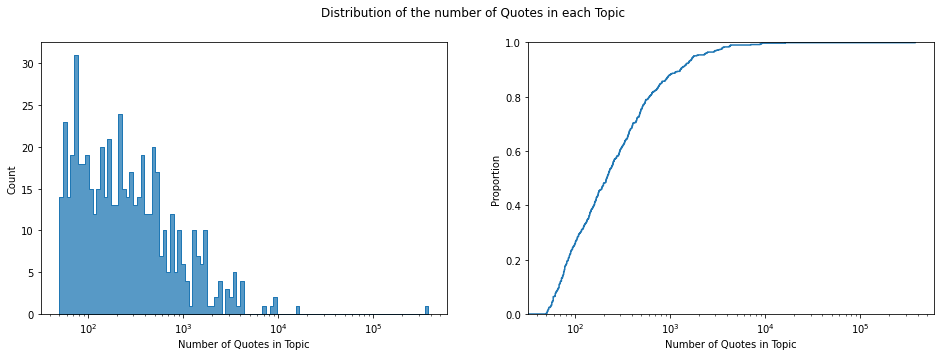

In [43]:
# Visualization of the distribution of the topic frequency.
plot.plot_hist_ecdf(bert_model.get_topic_info().rename(columns = {'Count': 'Number of Quotes in Topic'}),
                    x = 'Number of Quotes in Topic',
                    title = 'Distribution of the number of Quotes in each Topic', 
                    hist_kwargs = {'bins': 100, 'log_scale': (True, False), 'element': 'step'}, 
                    ecdf_kwargs = {'log_scale': (True, False)})

In [44]:
for topic in range(NUM_MOST_FREQUENT_TOPICS):
    print(f"Representative Words of Topic {topic}:")
    print(', '.join(elem for elem, _ in bert_model.get_topic(topic)), '\n')

Representative Words of Topic 0:
her, she, herself, hillary, clinton, lady, kim, sarah, actress, daughter 

Representative Words of Topic 1:
students, education, schools, teachers, classroom, teaching, educational, colleges, tuition, curriculum 

Representative Words of Topic 2:
defense, offense, plays, defensively, defensive, field, quarterback, players, turnovers, season 

Representative Words of Topic 3:
music, songs, band, sing, singing, musicians, concert, albums, musician, singer 

Representative Words of Topic 4:
cricket, pitches, wickets, innings, wicket, batting, bowled, hitter, hitters, batsman 

Representative Words of Topic 5:
fight, boxing, fighter, fights, ufc, conor, fighters, heavyweight, boxer, punches 

Representative Words of Topic 6:
food, restaurant, restaurants, meal, meals, chef, foods, dishes, chefs, recipes 

Representative Words of Topic 7:
insurance, healthcare, obamacare, medicaid, doctors, hospitals, medicare, nurses, insurers, aca 

Representative Words of

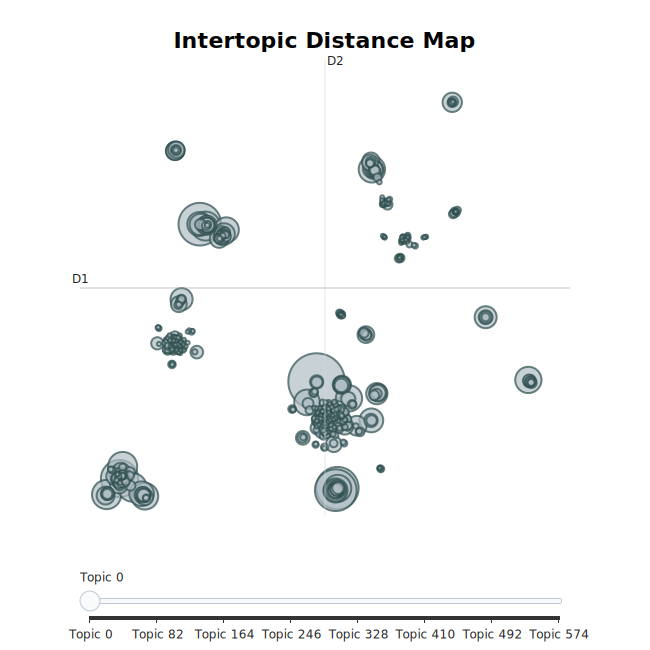

In [45]:
plot.plotly_to_svg(bert_model.visualize_topics())

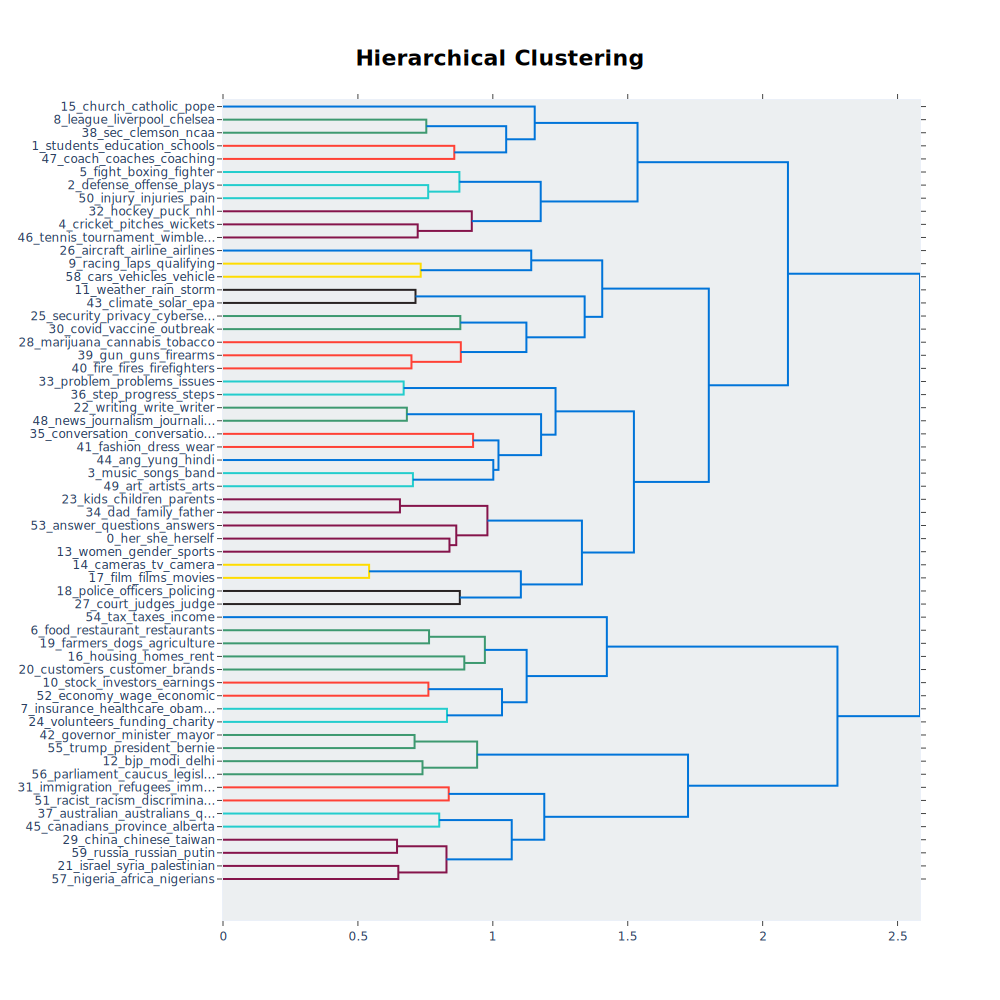

In [46]:
plot.plotly_to_svg(bert_model.visualize_hierarchy(top_n_topics = 60, height = 1000))

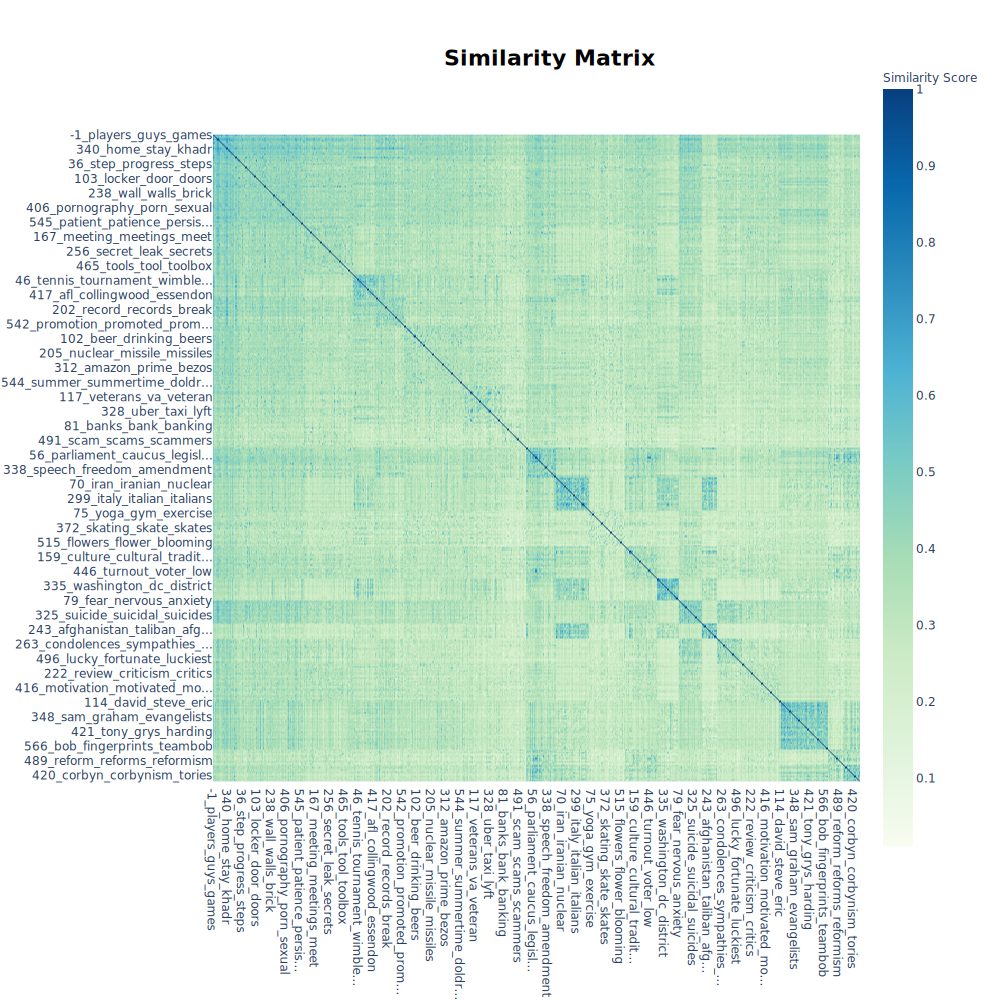

In [47]:
plot.plotly_to_svg(bert_model.visualize_heatmap(n_clusters = 20, width = 1000, height = 1000))

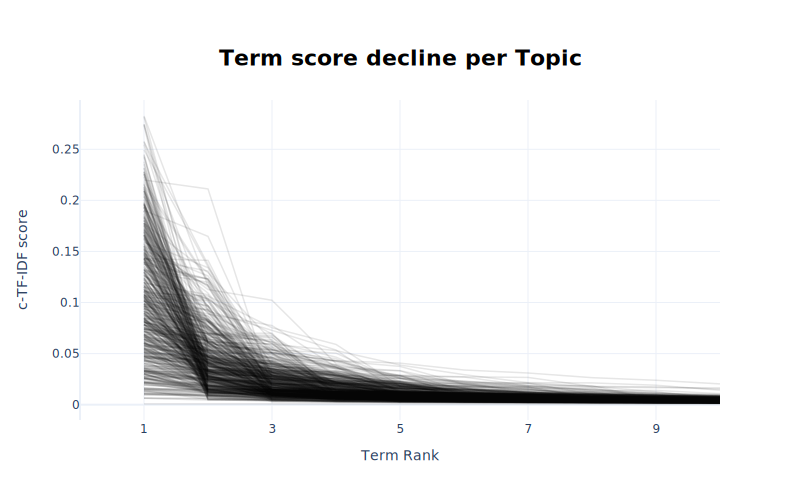

In [48]:
plot.plotly_to_svg(bert_model.visualize_term_rank())

In [49]:
# Cleanup temporary variable.
del bert_model

*__Note:__ if the above images do not display correctly, you need to trust this jupyter notebook. To do so, click on the button on the top right of the screen, just below the python logo and to the left of the pencil that says "Not Trusted".*

From the BERTopic model, we extract the 15 most frequent topics observed in the set of quotes used for training it. As we can see from the list of representative words associated with each topic, the obtained topics are simple to interpret. It should also be noted that, as we can see from the Term score graph, the first words associated with each topic are often sufficient by themselves to understand what the topic is about (the first few words are very representative of the quote, as the term score for most topics declines fast with the number of words, here labeled Term Rank on the x-axis).

It should be noted that as explained earlier, the topic labeled with -1 groups all documents which could not be clustered into one of the existing topics.

Therefore, when analyzing these results we should keep in mind the truly most frequent topic is topic 0. In our case, this topic contains female pronouns and names of the most relevant symbol of the female gender like Hillary Clinton. This is quite surprising since in the previous sections we have observed that female speakers are far less represented in the number of quotes with respect to male. One reason for why we may observe such a frequent topic may be due to the 2016 Unites States of America elections, which was certainly an event that was given huge media coverage, and one in which Donald Trump did not refrain from using Hilary Clinton's name in multiple occasions. The second most frequent topic can be labeled as education. This result can be expected since it also is a common discussion topic in politics. Topics 2, 4, 5, 8, and 9 contain all words that are related to sports like American football, baseball, fighting sports, football, and racing. This result too can be explained with the information obtained in the previous sections, since we have observed that males of USA nationality that plays American football and males of UK nationality playing football represent a big portion of the total quotes. Topic 3 can be labeled as music, topic 7 as healthcare insurance, topic 10 as finance or economics, topic 11 as climate, and topic 12 as middle East.

By interactively inspecting the inter-topic distance map and by simply looking at the hierarchical topics three, we can see that despite many topics have already been merged by the algorithm (BERTopic was trained with `nr_topics='auto'`, hence merging all topics with similitude larger than 0.9 and going from approximately 950 topics to 550) we observe that some topics are still quite similar and, in the scope of this project, it may make sense to merge them further. To do so, it would suffice to simply set an integer value for `nr_topics` and rerun the training.

<a id='build_features_labels'></a>
# 3. Building the feature matrix and the labels

Once the pretreated dataset is obtained and the BERTopic model trained, we can just parse the preprocessed dataset again converting each line into a feature vector and a label (viral / not viral).

In [50]:
@utils.cache_to_file_pickle("function-make_features_labels_arrays", cache_dir = CACHE_DIR, ignore_kwargs = ['batch_size'])
def make_features_labels_arrays(preprocessed_dataset_file_path, sentiment_thr = 0.05, batch_size = 1000000):
    
    @utils.cache_to_file_pickle("function-extract_topics_and_sentiments", cache_dir = CACHE_DIR, ignore_kwargs = ['batch_size'])
    def extract_topics_and_sentiments(preprocessed_dataset_file_path, batch_size):
        
        def process_batch_for_topics_and_sentiments(quotation_topic, quotation_sentiment, quotation_batch, bert_model, sentiment_extractor):
            # If list is empty, don't do anything otherwise BERTopic raises un exception.
            if quotation_batch:
                topics, _ = bert_model.transform(quotation_batch)

                # Simply add new topics to end of previous list.
                quotation_topic.extend( topics )
                quotation_sentiment.extend( [sentiment_extractor.polarity_scores(quote)['compound'] for quote in quotation_batch] )
                
            return quotation_topic, quotation_sentiment
        
        
        bert_model = get_trained_bert_model(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
        sentiment_extractor = SentimentIntensityAnalyzer()

        quotation_topic = []
        quotation_sentiment = []
        quotation_batch = []

        for line in utils.json_lines_generator(preprocessed_dataset_file_path):        
            quotation_batch.append(line['quotation'])

            if len(quotation_batch) >= batch_size:
                quotation_topic, quotation_sentiment = process_batch_for_topics_and_sentiments(quotation_topic, quotation_sentiment, quotation_batch, bert_model, sentiment_extractor)
                
                quotation_batch = []

        quotation_topic, quotation_sentiment = process_batch_for_topics_and_sentiments(quotation_topic, quotation_sentiment, quotation_batch, bert_model, sentiment_extractor)
        
        # Convert lists to numpy array.
        # Converting to numpy array allows for much more compact storage on disk cache.
        quotation_topic     = np.array(quotation_topic)
        quotation_sentiment = np.array(quotation_sentiment)
        
        return quotation_topic, bert_model.get_topic_info(), quotation_sentiment
    
    
    # Do and cache results of a first parsing extracting only the topics of the quotes. It is worth separating
    # this parsing because it alone takes days, hence any slight modification to other parts of this function
    # would cause massive slowdown in the project progress.
    quotation_topic, topic_number_names_map, quotation_sentiment = extract_topics_and_sentiments(preprocessed_dataset_file_path = preprocessed_dataset_file_path,
                                                                                                 batch_size = batch_size)
    
    # Second parsing to extract all features except the topics of the quotes.
    features_cols_titles = None
    
    features = []
    num_occurrences = []
    
    features_batch = []
    
    for line in utils.json_lines_generator(preprocessed_dataset_file_path):
        
        num_occurrences.append(line.pop('num_occurrences'))
        line.pop('quotation')
        
        if features_cols_titles is None:
            features_cols_titles = sorted(line)

        features_batch.append([line[key] for key in features_cols_titles])
                
        if len(features_batch) >= batch_size:
            # Convert sparse list of lists to COO sparse matrix.
            # COO sparse matrices have the advantage of being quick to generate and to stack.
            features.append( scipy.sparse.coo_matrix(features_batch) )
            features_batch = []
                
    # Add lines remaining in batch to list if batch is not empty.
    if features_batch:
        features.append( scipy.sparse.coo_matrix(features_batch) )
     
    # Merge list of sparse matrices into a single sparse matrix.
    # Using COO sparse format allows for fast stacking.
    features = scipy.sparse.vstack(features)
    
    # Convert lists to numpy array.
    num_occurrences = np.array(num_occurrences)
    
    # Categorize quotation sentiment into overall positive, negative or neutral.
    name_of_sentiment_col = [f'quotation_sentiment_{category.upper()}' for category in ['negative', 'neutral', 'positive']]
    one_hot_quotation_sentiments = np.stack([quotation_sentiment         <= -sentiment_thr, 
                                             np.abs(quotation_sentiment) < sentiment_thr, 
                                             quotation_sentiment         >= sentiment_thr], axis = 1)
    one_hot_quotation_sentiments = scipy.sparse.coo_matrix( one_hot_quotation_sentiments.astype(int) )
    
    # Add quotation sentiment as columns of feature matrix.
    features = scipy.sparse.hstack([features, one_hot_quotation_sentiments])
    features_cols_titles.extend(name_of_sentiment_col)    
    
    # Find unique topics to one-hot encode.
    unique_topics = np.unique(quotation_topic)

    # Associate a column index to each unique topic.
    col_of_topic = dict(zip(unique_topics, range(len(unique_topics))))

    # Retrieve for each topic its name in the same order as the column indices.
    topic_number_names_map = topic_number_names_map.set_index('Topic', drop = True)
    topic_number_names_map.at[-1, 'Name'] = 'unknown'

    name_of_topic_col = [f"quotation_topic_{topic_number_names_map.at[topic, 'Name'].upper()}" for topic in unique_topics]

    # Build sparse matrix one-hot encoding topics.
    topic_col = [col_of_topic[topic] for topic in quotation_topic]
    data = np.ones  (len(topic_col), dtype = 'int')
    rows = np.arange(len(topic_col))
    one_hot_quotation_topics = scipy.sparse.coo_matrix((data, (rows, topic_col)))
    
    # Add quotation topics as columns of feature matrix.
    features = scipy.sparse.hstack([features, one_hot_quotation_topics])
    features_cols_titles.extend(name_of_topic_col)
     
    # Convert sparse matrix from COO to CSR format for easy slicing later on.
    # As all features are categorical, can also convert them from np.int32 to np.uint8 to save memory.
    features = features.tocsr().astype(np.uint8)
    
    return features, num_occurrences, features_cols_titles

In [51]:
features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)

In [52]:
print(f"We have {features.shape[0]} datapoints and {features.shape[1]} features.")

We have 69068030 datapoints and 627 features.


# FOR SENTIMENT ANALYSIS: CHOICE OF COMPOUND SCORE BECAUSE IT IS MORE COMPLETE THAN JUST TAKING POS, NEG, NEUTRAL SEPARATELY (CHECK DOC FOR MORE DETAILS) AND THEN CHOSE TO DISCRETIZE IT WITH THR SUGGESTED IN THE DOC BECAUSE THIS WILL ALLOW FOLLOWING ML MODELS TO MODEL INDEPENDENTLY THE WEIGHT OF POSITIVE, NEGATIVE AND NEUTRAL QUOTES ON THE NUMBER OF OCCURRENCES (3 WEIGHTS LEARNT ALLOW TO MODEL NON-LINEAR RELATIONSHIP OF POSITIVE AND NEGATIVE, INSTEAD OF ONE WHICH CAN ONLY REPRESENT A LINEAR RELATION BETWEEN BEING POSITIVE AND NEGATIVE)

<a id='relationship_feature_output'></a>
# 4. Relationship between features and output

In this section, we analyze the relationship between the selected features and the output. At first the output will be taken as the binary label viral/not viral and afterwards we will take the output as the number of occurences directly.

### Useful functions

In [34]:
def get_plot_labels(raw_labels):
    """
    """
    return [raw_label.rpartition('_')[-1].title() for raw_label in raw_labels]

def get_feature_cols(features_title, name):
    """
    """
    return [features_title.index(col_name) for col_name in features_title if name in col_name]

def get_occurrences_for_features(features, features_titles, feature_name, occurrences):
    """
    """
    # Get index where features of interest.
    feature_cols = get_feature_cols(features_titles, feature_name)

    occurences_cols = []

    # Store occurences for each feature of interest.
    for column in feature_cols:
        occurences_cols.append(occurrences[(features[:, column] == 1).toarray().ravel()])
        
    return occurences_cols, get_plot_labels(list(np.array(features_titles)[feature_cols]))

def get_occurrences_for_one_feature(features, features_titles, feature_name, occurrences):
    """
    """
    # Get index where feature of interest.
    feature_col = get_feature_cols(features_titles, feature_name)

    dict_occurences = {}

    # Store occurences for each values of feature of interest.
    values_feature = [1, 0]
    
    for value in values_feature:
        occurences_col = occurrences[(features[:, feature_col] == value).toarray().ravel()]
        dict_occurences[features_titles[feature_col[0]] + str(value)] = occurences_col
        
    return dict_occurences

In [35]:
def plot_hist(data, color, bins, xlog = False, ylog = False, **kwargs):
    """Function allowing to plot an histogram of the provided data as well as a visualization of the mean and std
    of the data on top of the same histogram.
    
    Params:
        data::[iterable]
            Data we wish to plot the histogram of.
        color::[tuple]
            Color to use for the histogram and mean std visualization.
        bins::[int | iterable]
            If int, number of bins to use in the histogram. If iterable, numbers representing the breaks in consecutive bins.
        xlog::[bool]
            Boolean describing whether the x-axis should be in log scale.
        ylog::[bool]
            Boolean describing whether the x-axis should be in log scale.
        kwargs::[dict]
            Any additional arguments which should be passed to plt.hist call.
            
    Returns:
        bins::[np.array]
            Bins used in the histogram in the plot.
    """
    # Compute hist bins if necessary.
    if isinstance(bins, int):
        if xlog:
            bins = np.linspace(np.log10(data.min()), np.log10(data.max()), bins + 1)
        else:
            bins = np.linspace(data.min(), data.max(), bins + 1)
    
    # Draw histogram.
    sns.histplot(data, bins = bins, color = color, log_scale = (xlog, ylog), **kwargs)
    
    return bins

In [42]:
def plot_distr_occurrences_features(features, features_titles, feature_name, occurrences, plot = 'boxplot', figsize = (15, 6)):
    
    if plot == 'boxplot':
        
        # Retrieve occurrence for values possible for feature
        data, labels = get_occurrences_for_features(features, features_titles, feature_name, occurrences)
        
        # Plot distribution of the features of interest.
        plt.figure(figsize = figsize)
        plt.boxplot(data, notch = True, whis = 10000)
        plt.yscale('log')
        plt.xticks(range(1, len(labels) + 1), labels, rotation='vertical')
        plt.show()
        
    elif plot == 'overlapped_hist':
        
        # Retrieve occurrence for values possible for feature
        data, labels = get_occurrences_for_features(features, features_titles, feature_name, occurrences)
        
        # Plot distribution of the features of interest.
        plt.figure(figsize = figsize)
        palette = iter(sns.color_palette())
        bins = 250
        
        for occurences, label in zip(data, labels):
            bins = plot_hist(occurences, label = label, bins = bins, color = next(palette), element = "step", 
                             alpha = 0.5, xlog = True, ylog = True)
            
        plt.grid()
        plt.legend()
        plt.show()
        
    elif plot == 'non_overlapped_hist':
        
        # Retrieve occurrence for values possible for feature
        data, labels = get_occurrences_for_features(features, features_titles, feature_name, occurrences)
        
        # TO DO: KEEP IN A MORE MEANINGFUL WAY
        if len(labels) > 8:
            data, labels = data[10:], labels[10:]
            
        # Plot distribution of the features of interest.
        fig, axs = plt.subplots(nrows = 1, ncols = len(labels), figsize = figsize)
        palette = cycle(sns.color_palette())
        
        (x_min, x_max) = (1, 1)
        (y_min, y_max) = (1, 1)
        
        for occurences, label, ax in zip(data, labels, axs):
            bins = 250
            bins = np.linspace(np.log10(occurences.min()), np.log10(occurences.max()), bins + 1)
            
            # Draw histogram.
            ax.set_xscale('log')
            ax.set_yscale('log')
            sns.histplot(y = occurences, bins = bins, color = next(palette, "cornflowerblue"), element = "step", label = label,
                         alpha = 0.5, ax = ax)
            
            ax.legend(loc = "upper right")
            
            # Get xlim/ylim.
            (x_min_temp, x_max_temp) = ax.get_xlim()
            (y_min_temp, y_max_temp) = ax.get_ylim()
            
            if x_min_temp < x_min:
                x_min = x_min_temp
            if y_min_temp < y_min:
                y_min = y_min_temp
            if x_max_temp > x_max:
                x_max = x_max_temp
            if y_max_temp > y_max:
                y_max = y_max_temp
            
        
        axs[0].set_ylabel("Occurrences")
        plt.setp(axs, xlim=(x_min, x_max), ylim=(y_min, y_max))
        plt.show()
        
    else:
        raise ValueError(f"Parameter plot must be either 'boxplot', 'overlapped_hist' \
                          or 'non_overlapped_hist', given {plot}.")

### Data information

In [15]:
features_cols_titles

['number_words_quote',
 'speaker_gender_FEMALE',
 'speaker_gender_MALE',
 'speaker_gender_OTHER',
 'speaker_nationality_AUSTRALIA',
 'speaker_nationality_CANADA',
 'speaker_nationality_FRANCE',
 'speaker_nationality_GERMANY',
 'speaker_nationality_INDIA',
 'speaker_nationality_NEW ZEALAND',
 'speaker_nationality_UNITED KINGDOM',
 'speaker_nationality_UNITED STATES OF AMERICA',
 'speaker_occupation_ACTOR',
 'speaker_occupation_AMERICAN FOOTBALL PLAYER',
 'speaker_occupation_ASSOCIATION FOOTBALL PLAYER',
 'speaker_occupation_BASEBALL PLAYER',
 'speaker_occupation_BASKETBALL PLAYER',
 'speaker_occupation_BUSINESSPERSON',
 'speaker_occupation_CHIEF EXECUTIVE OFFICER',
 'speaker_occupation_COMPOSER',
 'speaker_occupation_ENTREPRENEUR',
 'speaker_occupation_FILM / TELEVISION PRODUCER',
 'speaker_occupation_FILM DIRECTOR',
 'speaker_occupation_INVESTOR',
 'speaker_occupation_JOURNALIST',
 'speaker_occupation_LAWYER',
 'speaker_occupation_MUSICIAN',
 'speaker_occupation_POLITICIAN',
 'speaker_

In [16]:
features.shape

(69064687, 613)

### Quotes unknown VS known topics

In [47]:
features[:,35:].mean(axis=0).max()

0.5660614958563805

In [48]:
dict_unknown = get_occurrences_for_one_feature(features, features_cols_titles, 'quotation_topic_UNKNOWN', num_occurrences)

C:\Users\celin\AppData\Local\Temp/ipykernel_5632/3632562657.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  dict_unknown = get_occurrences_for_one_feature(features, features_cols_titles, 'quotation_topic_UNKNOWN', num_occurrences)


In [53]:
len(dict_unknown['quotation_topic_UNKNOWN0'] > 100)

29969827

C:\Users\celin\AppData\Local\Temp/ipykernel_5632/4219648298.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  dict_occurences = get_occurrences_for_one_feature(features.tocsc(), features_cols_titles, 'quotation_topic_UNKNOWN',


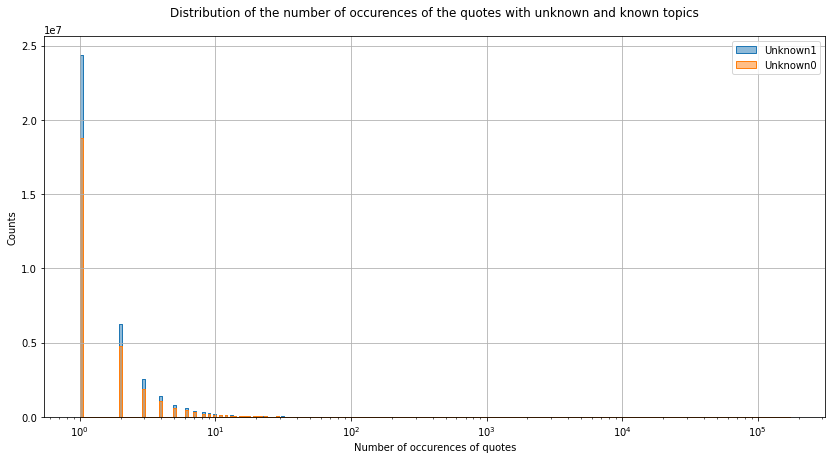

In [44]:
dict_occurences = get_occurrences_for_one_feature(features.tocsc(), features_cols_titles, 'quotation_topic_UNKNOWN', 
                                                  num_occurrences)
labels, data = get_plot_labels(dict_occurences.keys()), dict_occurences.values()

# Plot distribution of the features of interest.
plt.figure(figsize = (14, 7))
palette = iter(sns.color_palette())
bins = 250

for occurences, label in zip(data, labels):
    bins = plot_hist(occurences, label = label, bins = bins, color = next(palette), element = "step", 
                     alpha = 0.5, xlog = True, ylog = False)


plt.title("Distribution of the number of occurences of the quotes with unknown and known topics", pad=20)
plt.xlabel("Number of occurences of quotes")
plt.ylabel("Counts")

plt.grid()
plt.legend()
plt.show()

### Quotes speaker female vs male vs others

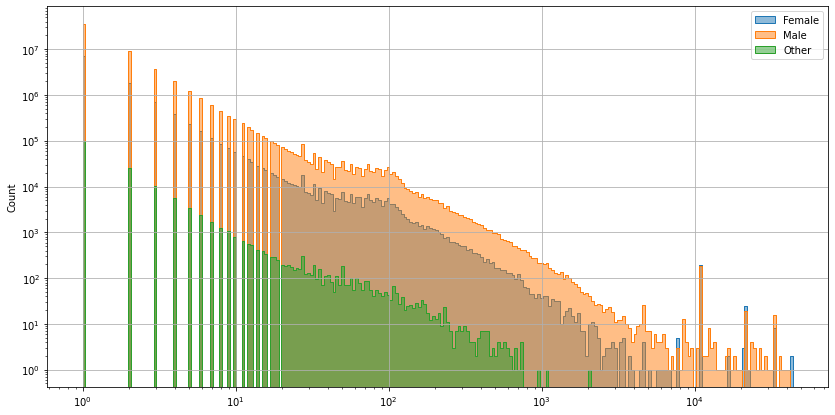

In [37]:
plot_distr_occurrences_features(features.tocsc(), features_cols_titles, "gender", num_occurrences, plot = 'overlapped_hist',
                                figsize = (14, 7))

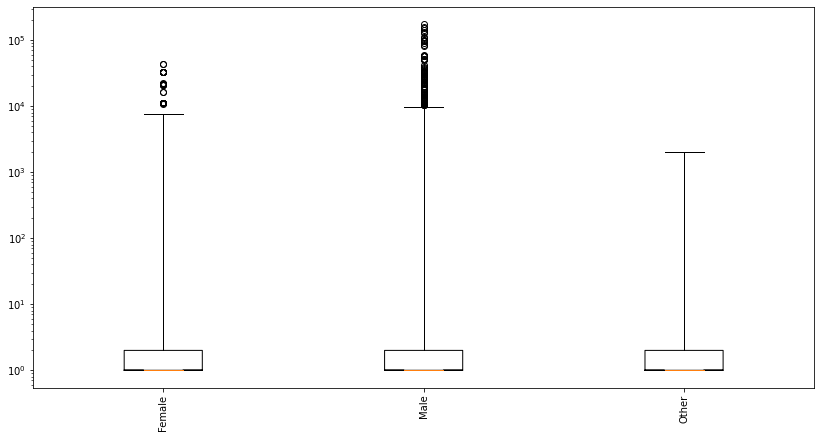

In [38]:
plot_distr_occurrences_features(features, features_cols_titles, 'gender', num_occurrences, figsize = (14, 7))

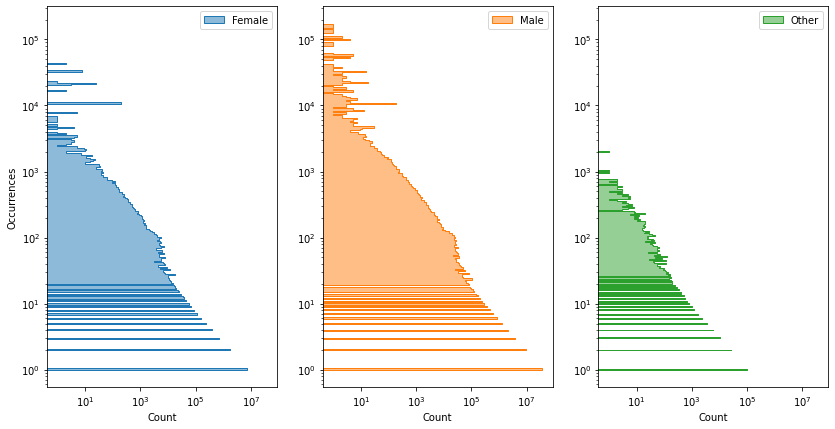

In [39]:
plot_distr_occurrences_features(features.tocsc(), features_cols_titles, "gender", num_occurrences, 
                                plot = 'non_overlapped_hist', figsize = (14, 7))

### Quotes speaker nationality

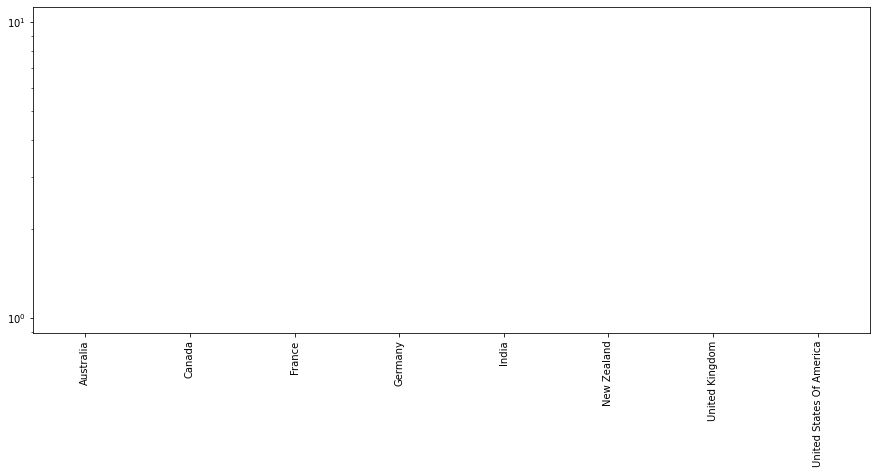

In [82]:
plot_distr_occurrences_features(features.tocsc(), features_cols_titles, "nationality", num_occurrences, plot = 'boxplot')

### Quotes speaker occupation

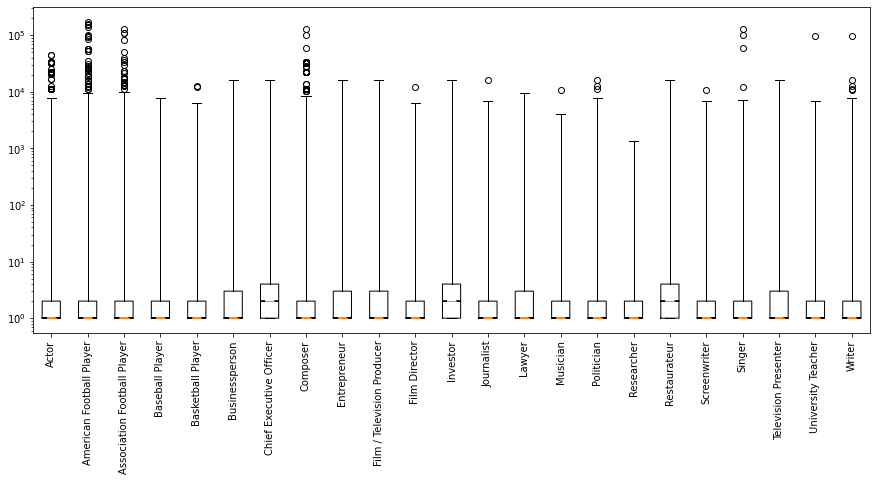

In [83]:
plot_distr_occurrences_features(features.tocsc(), features_cols_titles, "occupation", num_occurrences, plot = 'boxplot')

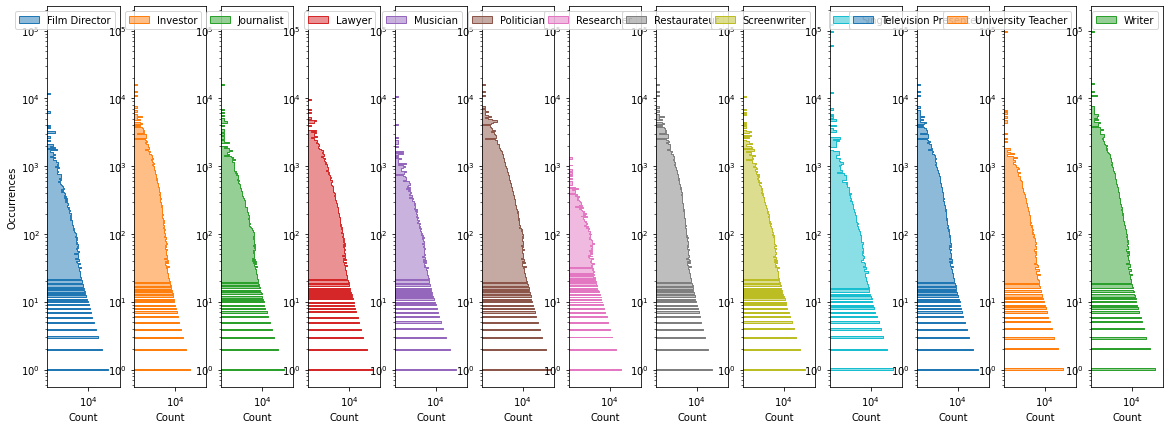

In [43]:
plot_distr_occurrences_features(features.tocsc(), features_cols_titles, "occupation", num_occurrences, 
                                plot = 'non_overlapped_hist', figsize = (20, 7))

<a id='training_classif'></a>
# 5. Training virality classifiers

<a id='theory_classif'></a>
## 5.A. Theoretical explanations of the methods used to perform the classification
[Back to table of content](#table_of_contents)

In this section, we will describe the mathematical models/concepts of the machine learning methods we will use in order to classify a quote as viral or not from some features previously selected. 

We will focus on 2 simple classification methods: logistic regression and the support vector machines. Additionally, we will describe the Cross-Validation method that will be used to select hyperparameters that are appropriate for each technique. And finally, we will explain how we split the data into the training and the test dataset.

<a id='logistic_reg_theory'></a>
### 5.A.a. Logistic Regression
The general statistical modeling scheme is:

$$ g(Y) = f(x) + error $$

In our case, Y is binary and x is continuous or binary, hence a simple Linear regression would not be suitable for a binary response.
For this reason, another model should be used. The Generalized Linear Models (GLMs) which are capable of modeling other types of response are then more suitable. 
In particular, as the response is binary, a commonly used GLM for this kind of problem is the binomial logistic regression. 
Like all GLMs, logistic regression allows the transformation of a linear model by a link function to relate to the response variable. 

GLMs are written on this form:

$$E[Y | x] = g^{-1}(\eta(x))$$

where:
- $E[Y | x]$ is the expected response $Y$ knowing the predictors $x$
- $g$ is the link function
- $\eta(x)$ is the linear predictor that depends on the predictors written here as a vector.

For binary logistic regression:
- $E[Y | x] = P(Y = 1 | x)$
- The link function is the logit function defined as $\displaystyle logit(x) = log \left(\frac{x}{1 - x} \right)$. Alternatively, it is also defined as the log of odds, where odds is defined as $\displaystyle odds(x) = \frac{x}{1 - x}$
- $\eta(x)$ is the linear predictor that depends on the predictors written here as a vector. For example if there is n predictors, $\eta(x) = \alpha_0 + x_1\alpha_1 ... + x_n\alpha_n$.

These elements put together in the GLM formula gives: $$logit(P(Y = 1 | x)) = \eta(x) \Rightarrow P(Y = 1 | x) = \frac{e^{\eta(x)}}{1 + e^{\eta(x)}} $$

We need to train the model in order to find the linear predictor's parameters $alpha_i$. This is typically done using a gradient descent algorithm minimizing the binary cross-entropy loss.

For this model to be acceptable, there are some assumptions:
- There is a binary output.
- The observation is independent and the sample size should be large.
- The link function is appropriate and then there is a linear relationship between the predictors and the log of odds.
- There is no multicollinearity between the predictors.
- There are no outliers.

<a id='svm_theory'></a>
### 5.A.b. Support Vector Machines
Support Vector Machines (SVMs) are supervised classifying machine learning techniques often used in binary classification. The idea of SVM is to generalize and extend a simple modeling technique called a maximum margin classifier. The principle of the maximum margin classifier is to construct a multi-dimensions hyperplane to split the classes by their features. This hyperplane is optimized such that the distance to the data points is maximal, and hence the margins are maximal. Nevertheless, this technique only works when the 2 classes are completely separable which is not likely. SVM technique generalizes this concept by allowing the classifier to have some misclassified data points to allow more robustness of the classifier towards individual datapoints and to better classify most of the datapoints even at the cost of misclassifying some of them.

To find the separating hyperplanes of SVM, we must do a gradient descent minimizing some loss. This loss is composed of 2 terms:
- The hinge loss which doesn't penalize correctly classified samples, but penalizes the incorrectly classified samples proportionnaly to the distance of the datapoint to the margin: 
$$\displaystyle L_{Hinge}(w, b;x_i, b_i) = max(0, 1 - y_i(w^Tx_i - b)) $$


- A penalty term to penalize more or less the data on the wrong side of the margin (lambda is a hyperparameter to tune and the lower it is the more the violation of the margins is penalized): 
$$\displaystyle \lambda||w||^2 $$

We will then find the parameters $w$ and $b$ describing the hyperplanes of SVM.

We want to apply this to model our data because we have 2 classes (viral/non-viral), this is a simple model to start with and it is linear. If results were to show that a linear classifier is not sufficient, we can try to apply a kernel to the SVM such that it allows us to model more complex decision boundaries.

<a id='cv_theory'></a>
### 5.A.c. K-fold Cross-Validation
The k-fold cross-validation method is widely used to try making an estimate of the test error of a model. The principle is to divide the training set into $k$ random splits, train the model on $k-1$ elements, and use the last $k$ bit to validate the model (estimate the error). In the end, the estimation of the test error will be the average of the error estimated on each fold. This will allow us to calibrate the parameters of the model (learning rate, regularization parameters, etc) and to detect underfitting or overfitting.

<a id='train_test_theory'></a>
### 5.A.d. Train/Test split of the dataset
In order to evaluate how our model performs on unseen data, we need to split our dataset into 2 sets:
- `Training set`: This set will be used to train our models and to perform the cross-validation.
- `Test set`: This set will not be used until the very end to assess the performance of our models on an unseen portion of the dataset.

We will take 70% of the dataset to train our classifiers and perform the cross-validation, and we will keep 30% of the dataset unseen to test our found classifier.

<a id='classification_feature_selection'></a>
## 5.B. Feature Selection for Classification
[Back to table of content](#table_of_contents)

SHORT DESCRIPTION NEEDED

In [ ]:
def choose_features(features, labels, cv_n_splits = 5, downsampling_factor = 100):
    
    
    
    # Use train_test_split to downsample dataset in a stratified manner.
    _, features, _, labels = train_test_split(features, labels,
                                              test_size = 1 / downsampling_factor,
                                              shuffle = True,
                                              stratify = labels)
    
    
    parameters = {'penalty': ('l1'), 'C': np.logspace(-3, -2, 2)}

    res = GridSearchCV(LinearSVC(dual = False, max_iter = 200), 
                       parameters,
                       scoring = {'accuracy' : 'accuracy',
                                  'precision': 'precision',
                                  'recall'   : 'recall',
                                  'f1'       : 'f1',
                                  'sparsity' : lambda estimator, X, y: np.mean(np.abs(estimator.coef_) < 1e-8)}, 
                       refit = False,
                       verbose = 2,
                       return_train_score = True,
                       cv = StratifiedKFold(cv_n_splits)).fit(features, labels)

    df = pd.DataFrame(res.cv_results_)
    df = df[[col for col in df.columns if col.startswith('param_') or re.match(r'^(mean|std)_(train|test)_', col)]]

    # Changing names of sparsity columns and dropping duplicates.
    df = df.drop(columns = ['mean_test_sparsity', 'std_test_sparsity']).rename(columns = {'mean_train_sparsity': 'mean_sparsity',
                                                                                          'std_train_sparsity' : 'std_sparsity'})
    return df

<a id='stratified_train_test_split'></a>
## 5.C. Splitting Data into Training and Testing in a Stratified Manner
[Back to table of content](#table_of_contents)

SHORT DESCRIPTION NEEDED

In [2]:
# Seed numpy for reproducibility of all following code.
np.random.seed(0x616461)

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

In [12]:
viral_label = np.int32(num_occurrences > VIRAL_THR)

splits = train_test_split(features, num_occurrences, viral_label,
                          test_size = 0.3,
                          shuffle = True,
                          stratify = viral_label)
                                                  
features_train, features_test, num_occurrences_train, num_occurrences_test, viral_label_train, viral_label_test = splits

# Cleanup temporary variables.
del splits, features, num_occurrences, viral_label

<a id='training_regression'></a>
# 6. Regressing number of occurences

<a id='theory_reg'></a>
## 6.A. Theoretical explanations of the methods used to perform the regression
[Back to table of content](#table_of_contents)

In this section, we will describe the mathematical models/concepts of the machine learning methods we will use in order to regress the occurrence of a quote from some features previously selected. 

We will focus on a simple regression method: linear regression.

<a id='lin_reg_theory'></a>
### 6.A.a. Linear Regression

Regression problems are problems aiming at finding a function $f$ that estimates the relationship between categorical or continuous inputs and an output continuous variable.

Linear regression is a specific modelling technique to resolve regression problems. Specifically, it is a model in which we assume that the output variable can be predicted from a linear combination of the input variables such that: 

$$Y = f(X) = \alpha_0 + x_1\alpha_1 ... + x_n\alpha_n$$

Training of the model aims to find the coefficients $\alpha_i$. To find these, we typically minimize the mean squared error (MSE) defined as follows:

$$L_{MSE}(\alpha; x_i, y_i) = (y_i - f(\alpha; x_i))^2$$

We will also try to add $L2$ or $L1$ regularization terms to push the less meaningful terms towards 0 which will improve the interpretability of the results. In case of the linear regression with no regularization or with $L2$ regularization the solution has a closed-form. For $L1$ regularization there is no closed-form solution. When a closed-form solution is not available, linear regression can be solved via gradient descent. Even if a closed-form solution is available, it should be noted that it may require large amounts of memory to be computed for large training sets.

We want to start with linear regression for multiple reasons. The first one is that it is a simple, easy-to-train model which will allow us to handle bigger subsets of the dataset for training in a reasonable time. It's also interesting to see if linear relationships are enough to achieve rather good accuracy for such a complex dataset and it will constitute a good indicator as to whether low bias can be achieved with such a low complexity model.

For this model to be acceptable, there are some assumptions:
- The relationship between $X$ and $Y$ (features and quote count popularity) are linearly related. This might not be the case but we want to see if it is by gauging the accuracy of the model.

- The observations are independent of each other. Of course, this can never truly be the case in such a huge dataset influenced by extremely popular extremely quoted individuals, real-world events, and a ton of other params but we still think that we can apply this model with some amount of success.